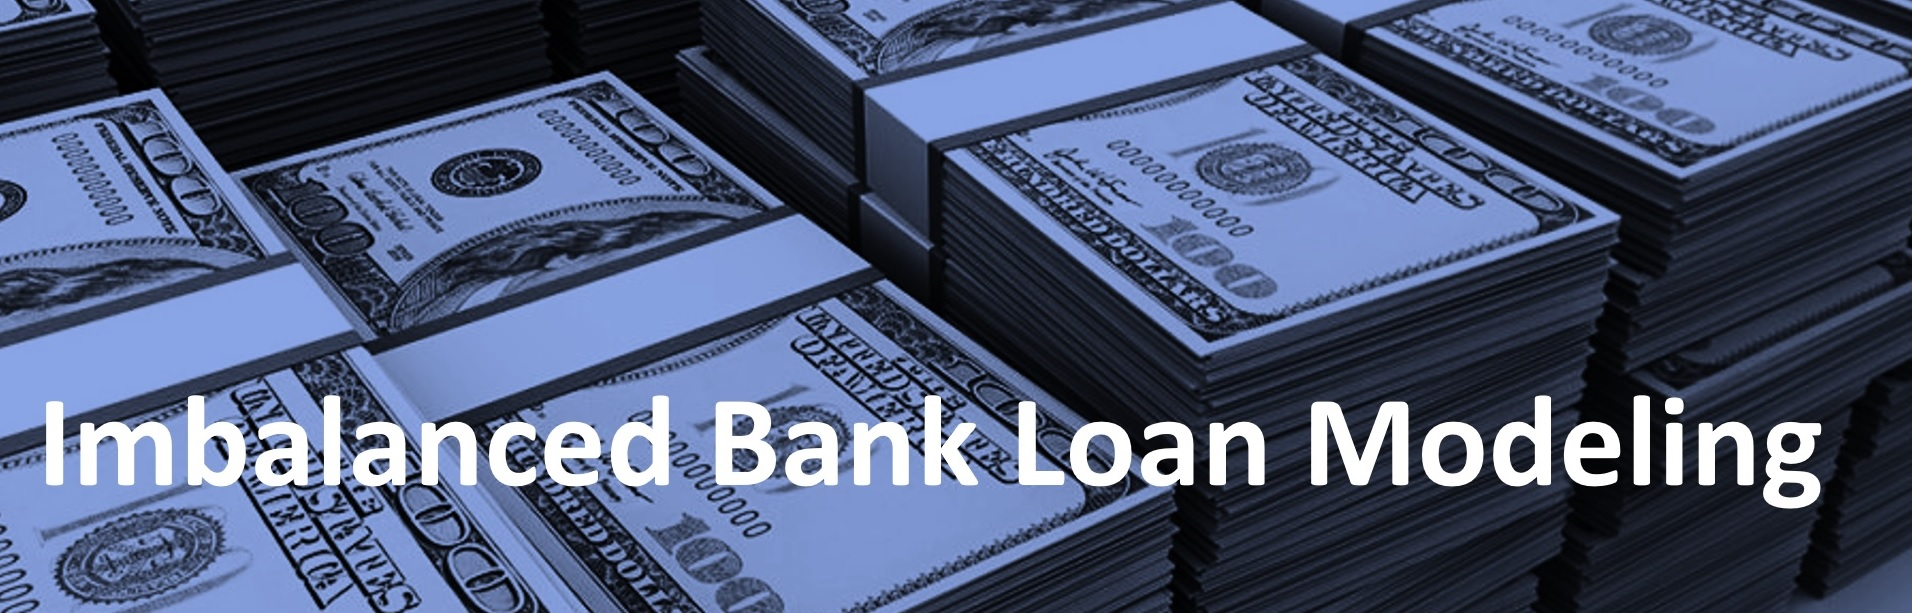

In this project, we will solve a problem for classifying personal loans on the __Thera-Bank dataset__. The majority of Thera-Bank's customers are depositors. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in quickly expanding this base to do more loan business while earning more through loan interest. In particular, management wants to look for ways to convert its liability customers into retail loan customers while keeping them as depositors. A campaign the bank ran last year for deposit customers showed a conversion rate of over 9.6% success. This has prompted the retail marketing department to develop campaigns with better target marketing to increase the success rate with a minimal budget. The department would like to develop a classifier that will help them identify the potential customers who are more likely to purchase the loan. This will increase the success rate while reducing the cost of the campaign.

The dataset contains both customer information and customer response to the last personal loan campaign:

* __ID__: ID of the customer

* __Age__: Age of the customer in completed years

* __Experience__: Amount of work experience in years

* __Income__: Amount of annual income (in thousands)

* __Zipcode__: Postal code in which the client lives

* __Family__: Number of family members

* __CCAvg__: Average monthly spending with the credit card (in thousands)

* __Education__: Education level (1: bachelor's degree, 2: master's degree, 3: advanced/professional degree)

* __Mortgage__: Value of home mortgage, if any (in thousands)

* __Securities Account__: Does the customer have a securities account with the bank?

* __CD Account__: Does the customer have a certificate of deposit account (CD) with the bank?

* __Online__: Does the customer use the internet banking facilities?

* __CreditCard__: Does the customer use a credit card issued by the bank?

* __Personal Loan__: Did this customer accept the personal loan offered in the last campaign? (Target Variable)

__Objective:__ To use different classification models to predict the likelihood that a customer will buy a personal loan. 

__Let's get started:__

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 1: Import Libraries</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler
from sklearn.naive_bayes import ComplementNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from scipy import stats
from sklearn.base import clone 
%matplotlib inline

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 2: Read Dataset</p>

In [2]:
df = pd.read_excel(r'C:\Users\parha\Documents\Data_Analysis_projects\bank_loan\Bank_Personal_Loan_Modelling.xlsx',sheet_name='Data')
df.head(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 3: Dataset Univariate Analysis</p>

In [3]:
def check_detail(dataframe):
    d = {'SHAPE': dataframe.shape,
        'COLUMNS': dataframe.columns,
        'INDEX': dataframe.index,
        'VALUE TYPES': dataframe.dtypes,
        'DUPLICATED VALUES': dataframe.duplicated().sum(),
        'NUMBER OF UNIQUE VALUES': dataframe.nunique(),
        'ANY MISSING VALUES': dataframe.isnull().values.any(),
        'MISSING VALUES': dataframe.isnull().sum(),
        'DESCRIBE.T': dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T}
    hashtags = '---------------------------'
    for key, val in d.items():
        print(f'{hashtags} {key} {hashtags}')
        print(val)
    print(f'{hashtags} {"LIST END"} {hashtags}')
   

check_detail(dataframe=df)

--------------------------- SHAPE ---------------------------
(5000, 14)
--------------------------- COLUMNS ---------------------------
Index(['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal Loan', 'Securities Account',
       'CD Account', 'Online', 'CreditCard'],
      dtype='object')
--------------------------- INDEX ---------------------------
RangeIndex(start=0, stop=5000, step=1)
--------------------------- VALUE TYPES ---------------------------
ID                      int64
Age                     int64
Experience              int64
Income                  int64
ZIP Code                int64
Family                  int64
CCAvg                 float64
Education               int64
Mortgage                int64
Personal Loan           int64
Securities Account      int64
CD Account              int64
Online                  int64
CreditCard              int64
dtype: object
--------------------------- DUPLICATED VALUES 

In [4]:
df.drop('ID', axis=1, inplace=True) 

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 4: Correlation Analysis</p>

Let's compare __Spearman__'s correlation with __Pearson__'s correlation:

*  Pearson works with a linear relationship between the two variables whereas the Spearman works with monotonic relationships as well.
* Pearson works with raw data values of the variables whereas Spearman works with rank-ordered variables.


When the variables have a "might be monotonic, might be linear" relationship, our best bet is to use __Spearman__ rather than Pearson:

In [5]:
# Define a colormap
royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
royalblue_r = royalblue.reversed()

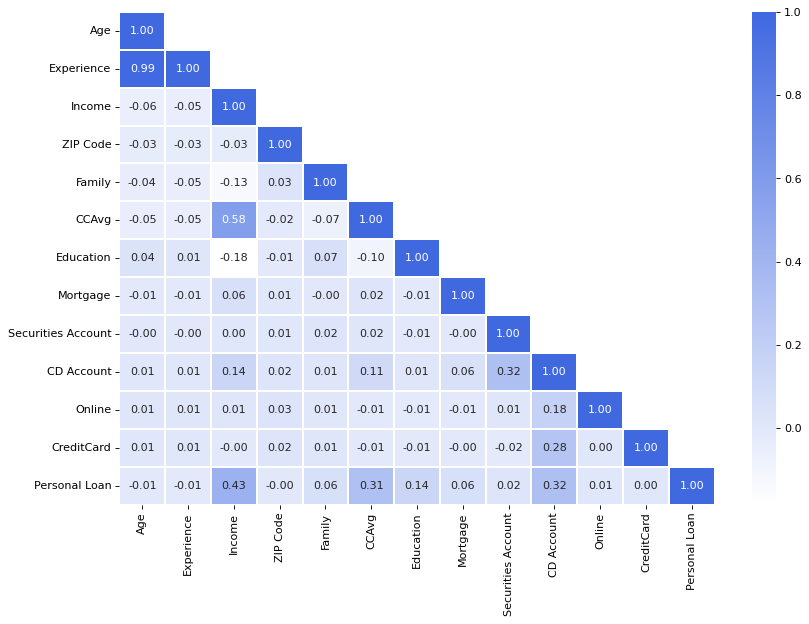

In [6]:
# Calculation of the Spearman correlation
target = 'Personal Loan'
df_ordered = pd.concat([df.drop(target,axis=1), df[target]],axis=1)
corr = df_ordered.corr(method='spearman')

# Create a mask so that we see the correlation values only once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

# Plot the heatmap correlation
plt.figure(figsize=(12,8), dpi=80)
sns.heatmap(corr, mask=mask, annot=True, cmap=royalblue, fmt='.2f', linewidths=0.2)
plt.show()

<h4 align="left"><font color='lightblue'>Conclusion:</font></h4>

* __Personal Loan__ is highly correlated with __Income, CD_Account, CCAvg__.
* __Experience__ is highly correlated with __Age__. (ρ = 0.99)
* __CCAvg__ is correlated with __Income__ to a good extent. (ρ = 0.58)

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 5: Data Cleansing</p>

__Data cleansing__, also known as data cleaning, is the process of preparing and structuring raw data to be used for further analysis. It includes identifying and correcting incorrect or incomplete data, removing irrelevant data, filling in missing values, and transforming existing variables. Data cleaning is an essential step in any machine learning project because it helps improve the accuracy of a model by reducing noise and errors. Poorly cleaned data can lead to overly complex models which are difficult to interpret and have a high chance of overfitting. Furthermore, dirty data can significantly reduce the accuracy of a model; even a small amount of noise will decrease its performance drastically.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 5.1: Noise Treatment</p>

__Noise treatment__ is the process by which irrelevant or noisy sections of a dataset are removed before the data can be used for analysis.

<h3 align="left"><font color='lightblue'>I) ZIP Code Noise Treatment:</font></h3>

In the 3d step, we found that the __ZIP Code__ feature has a minimum value that is much smaller than the average value. Let us look at the histogram of this feature again:

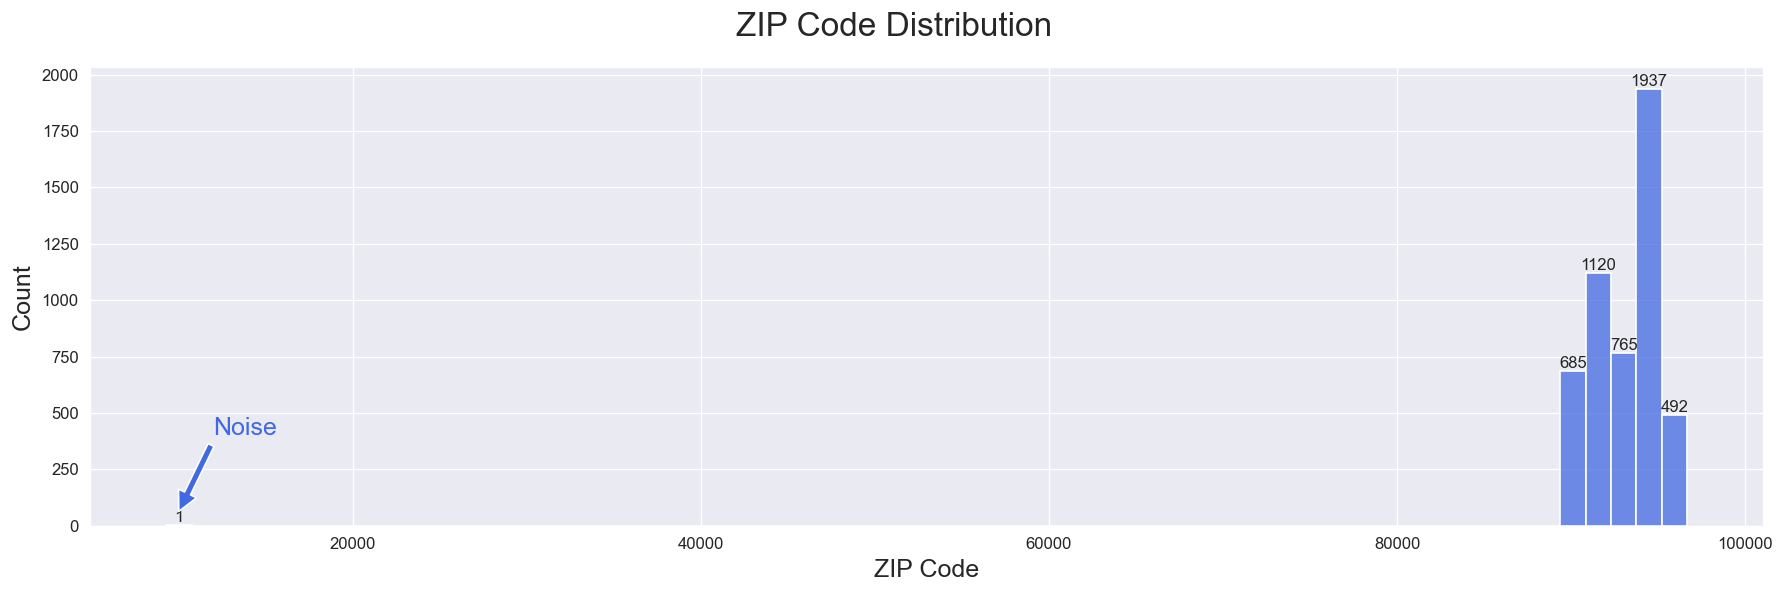

In [7]:
# Set the style of the graph
sns.set_style('darkgrid')
color = 'royalblue'

# Plot histogram
plt.figure(figsize=(15,5), dpi=120)
graph = sns.histplot(x='ZIP Code', data=df, bins=60, color=color)

# Show non-zero values of the individual bars
labels = [str(v) if v else '' for v in graph.containers[0].datavalues]
graph.bar_label(graph.containers[0], labels=labels)

plt.annotate('Noise', xy=(10000,60), xytext=(12000,400), color=color, fontsize=15, 
             arrowprops=dict(facecolor=color, shrink=0.01))
plt.xlabel('ZIP Code', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.suptitle('ZIP Code Distribution', fontsize=20)
plt.tight_layout()
plt.show()

In [8]:
df[df['ZIP Code']<20000]

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
384,51,25,21,9307,4,0.6,3,0,0,0,0,1,1


We found 1 noisy data in ZIP Code. We drop the corresponding sample because it contains 4 digits, while the other values of this feature all have 5 digits:

In [9]:
df.drop(df[df['ZIP Code']<20000].index, inplace=True)
df.reset_index(drop=True, inplace =True)

<h3 align="left"><font color='lightblue'>II) Experience Noise Treatment:</font></h3>

As seen in the third step, the dataset contains negative values for Experience. Considering that the values of this feature indicate work experience in years, these negative values are considered noise:

In [10]:
df[df['Experience']<0]['Experience'].count()

52

Count unique negative values:

In [11]:
df[df['Experience']<0]['Experience'].value_counts()

Experience
-1    33
-2    15
-3     4
Name: count, dtype: int64

Since the number of these noise values in the Experience feature is small, we assume that these values are incorrectly recorded as negative and replace them with their absolute value:

In [12]:
df['Experience'] = df['Experience'].apply(abs)

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 5.2: Outlier Treatment</p>

__Outliers__ are data points that are significantly higher or lower than most other values in the set.

__Kurtosis__ is a measure of the "tailedness" or shape of a distribution. If the Kurtosis value is greater than 3, it is likely that the variable contains outliers. This is because excessive kurtosis indicates that the data points have a higher concentration in the tails than normal, which may indicate the presence of outliers.

In 3d step, of all the continuous features, only the __Mortgage__ feature had a kurtosis value above 3. To detect possible outliers in this feature, we use __Z-score technique__.

Let us look at the distribution of Mortgage again:

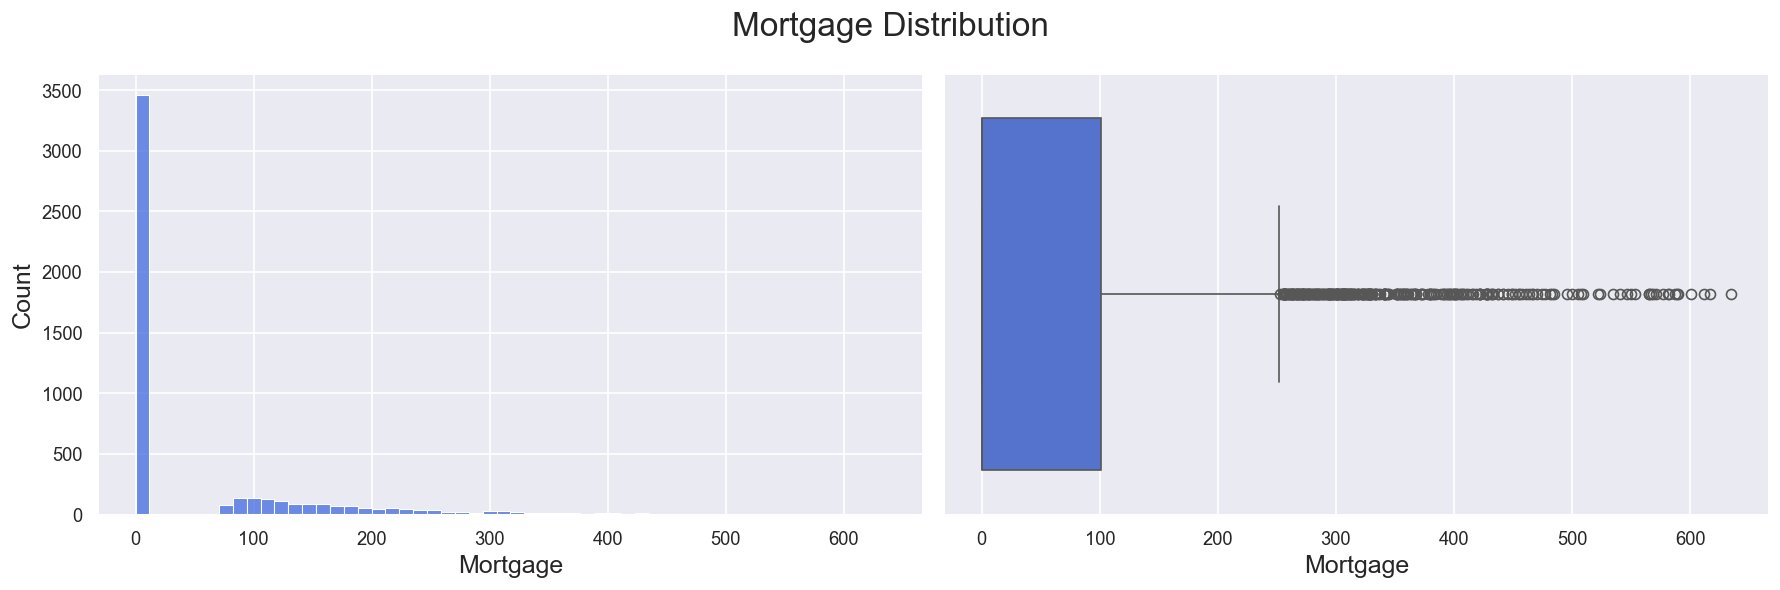

In [13]:
sns.set(rc = {'axes.labelsize' : 15})               
fig, ax = plt.subplots(1, 2, figsize=(15,5), dpi=120)
sns.histplot(x='Mortgage', data=df, color='royalblue', ax=ax[0])
sns.boxplot(x='Mortgage', data=df, color='royalblue', ax=ax[1])
plt.suptitle('Mortgage Distribution', fontsize=20)
plt.tight_layout()
plt.show()

The __Z-score__ method for outlier detection is a statistical technique used to detect outliers from data sets by calculating how many standard deviations away from the mean each data point is. A data point with a Z score of more than 3 standard deviation away from the mean is considered an outlier. We use the __scipy.stats__ module to perform the zscore technique:

In [14]:
df[stats.zscore(df['Mortgage'])>3]['Mortgage'].count()

105

We found 105 records with a Z-score mortgage value greater than 3. Therefore, we consider these 105 records as outliers and filter out these records from our dataset:

In [15]:
outlier_indexes = df[stats.zscore(df['Mortgage'])>3].index
df.drop(outlier_indexes, inplace=True)
df.reset_index(drop=True, inplace=True)

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 5.3: Missing Value Treatment</p>

In the 3rd step, we found that our dataset does not contain any __missing values__. Now let us check again if there is any missing value:

In [16]:
df.isnull().sum().sum()

0

It is clear that the dataset does not contain any missing values.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 5.4: Duplicate Values Treatment</p>

__Duplicate Values Treatment__ is the process of removing duplicate records from the dataset before feeding them into a machine learning algorithm. This is to ensure that only unique samples are used to train and evaluate the machine learning algorithm:

In [17]:
df[df.duplicated(keep=False)].sum().sum()

0.0

It is clear that the dataset does not contain duplicates.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 5.5: Feature Transformation</p>

In the dataset, CCAVG represents average monthly credit card spending, but Income represents the amount of annual income.
To make the units of the features equal, we convert average monthly credit card spending to annual:

In [18]:
df['CCAvg'] = df['CCAvg']*12

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 6: Bivariate Analysis</p>

Having considered each variable individually in univariate analysis in Step 3, we will now examine them again with respect to the __Target Variable__.

First, we will identify the relationship between the __Target Variable__ and the __Categorical Features__. Then we will look at the __Numerical Features__ compared to the __Target Variable__.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 6.1: Categorical Features vs Target</p>

In this part, we will create __100% stacked bar and column charts__ showing the proportion of purchased and non-purchased loans for each category of categorical features seprately:

In [19]:
# Define a list containing the names of important categorical features in the dataset 
Cat_Features = ['CD Account','Education','Family','Securities Account','Online','Securities Account']

# Define the target name in a variable for simplicity
Target = 'Personal Loan'

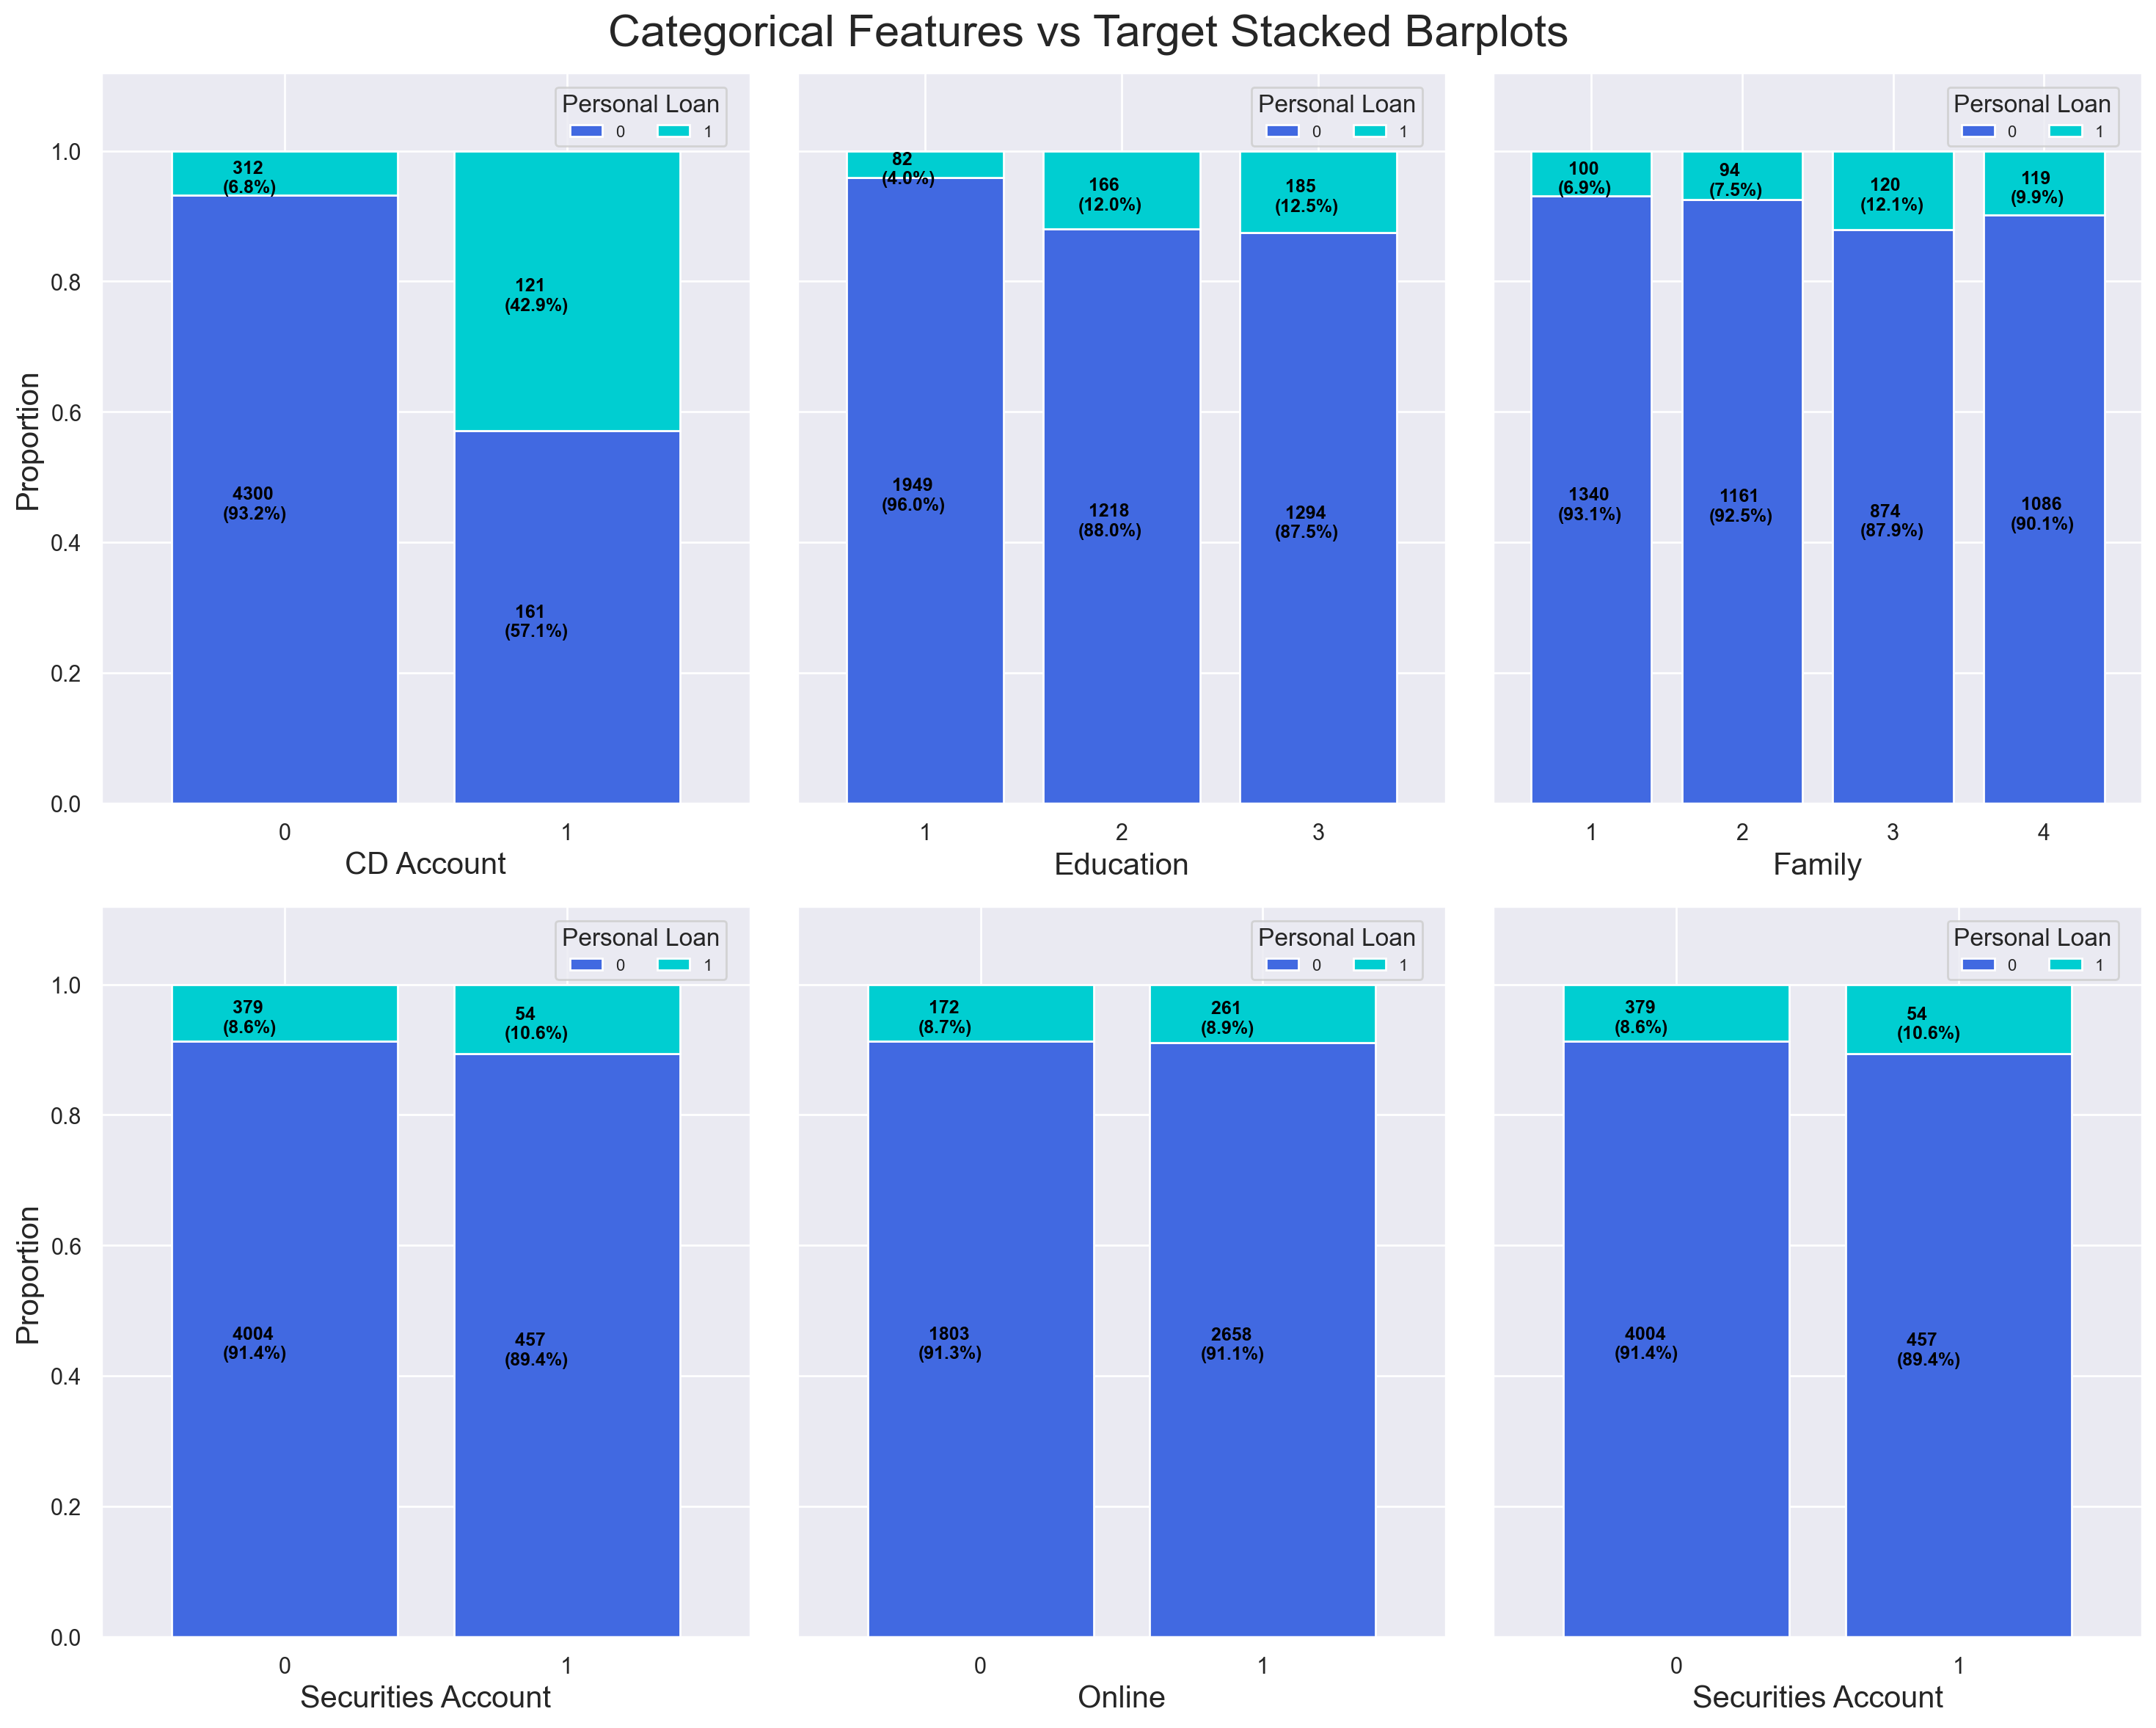

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,12), dpi=200)

for i,col in enumerate(Cat_Features):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df[Target])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df[Target], normalize='index')

    # Define colormap
    cmp = ListedColormap(['royalblue', 'darkturquoise'])
    
    # Plot stacked bar charts
    x, y = i//3, i%3
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.22, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'  {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='Personal Loan', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
            

plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

<h4 align="left"><font color='lightblue'>Conclusion:</font></h4>

* The customer who has a certificate of deposit (CD) with the bank appears to buy personal loans from the bank.

* Customers with higher levels of education are more likely to buy personal loans.

* The number of family members has no significant effect on the probability of buying personal loans.

* Customers who have or do not have a securities account at the bank have no influence on the probability of buying a personal loan.

* The customer who uses or does not use internet banking does not seem to have any influence on the probability of buying a personal loan.

* The customer who uses or does not use a credit card does not appear to have an impact on the likelihood of purchasing a personal loan.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 6.2: Numerical Features vs Target</p>

In this part, we will try to find the __mean__ and __distribution__ of numerical features for which customers purchase a personal loan versus the mean and distribution of numerical features who do not:

In [21]:
# Define a list containing the names of important numerical features in the dataset 
Num_Features = ['CCAvg','Income','Mortgage','Age','Experience']

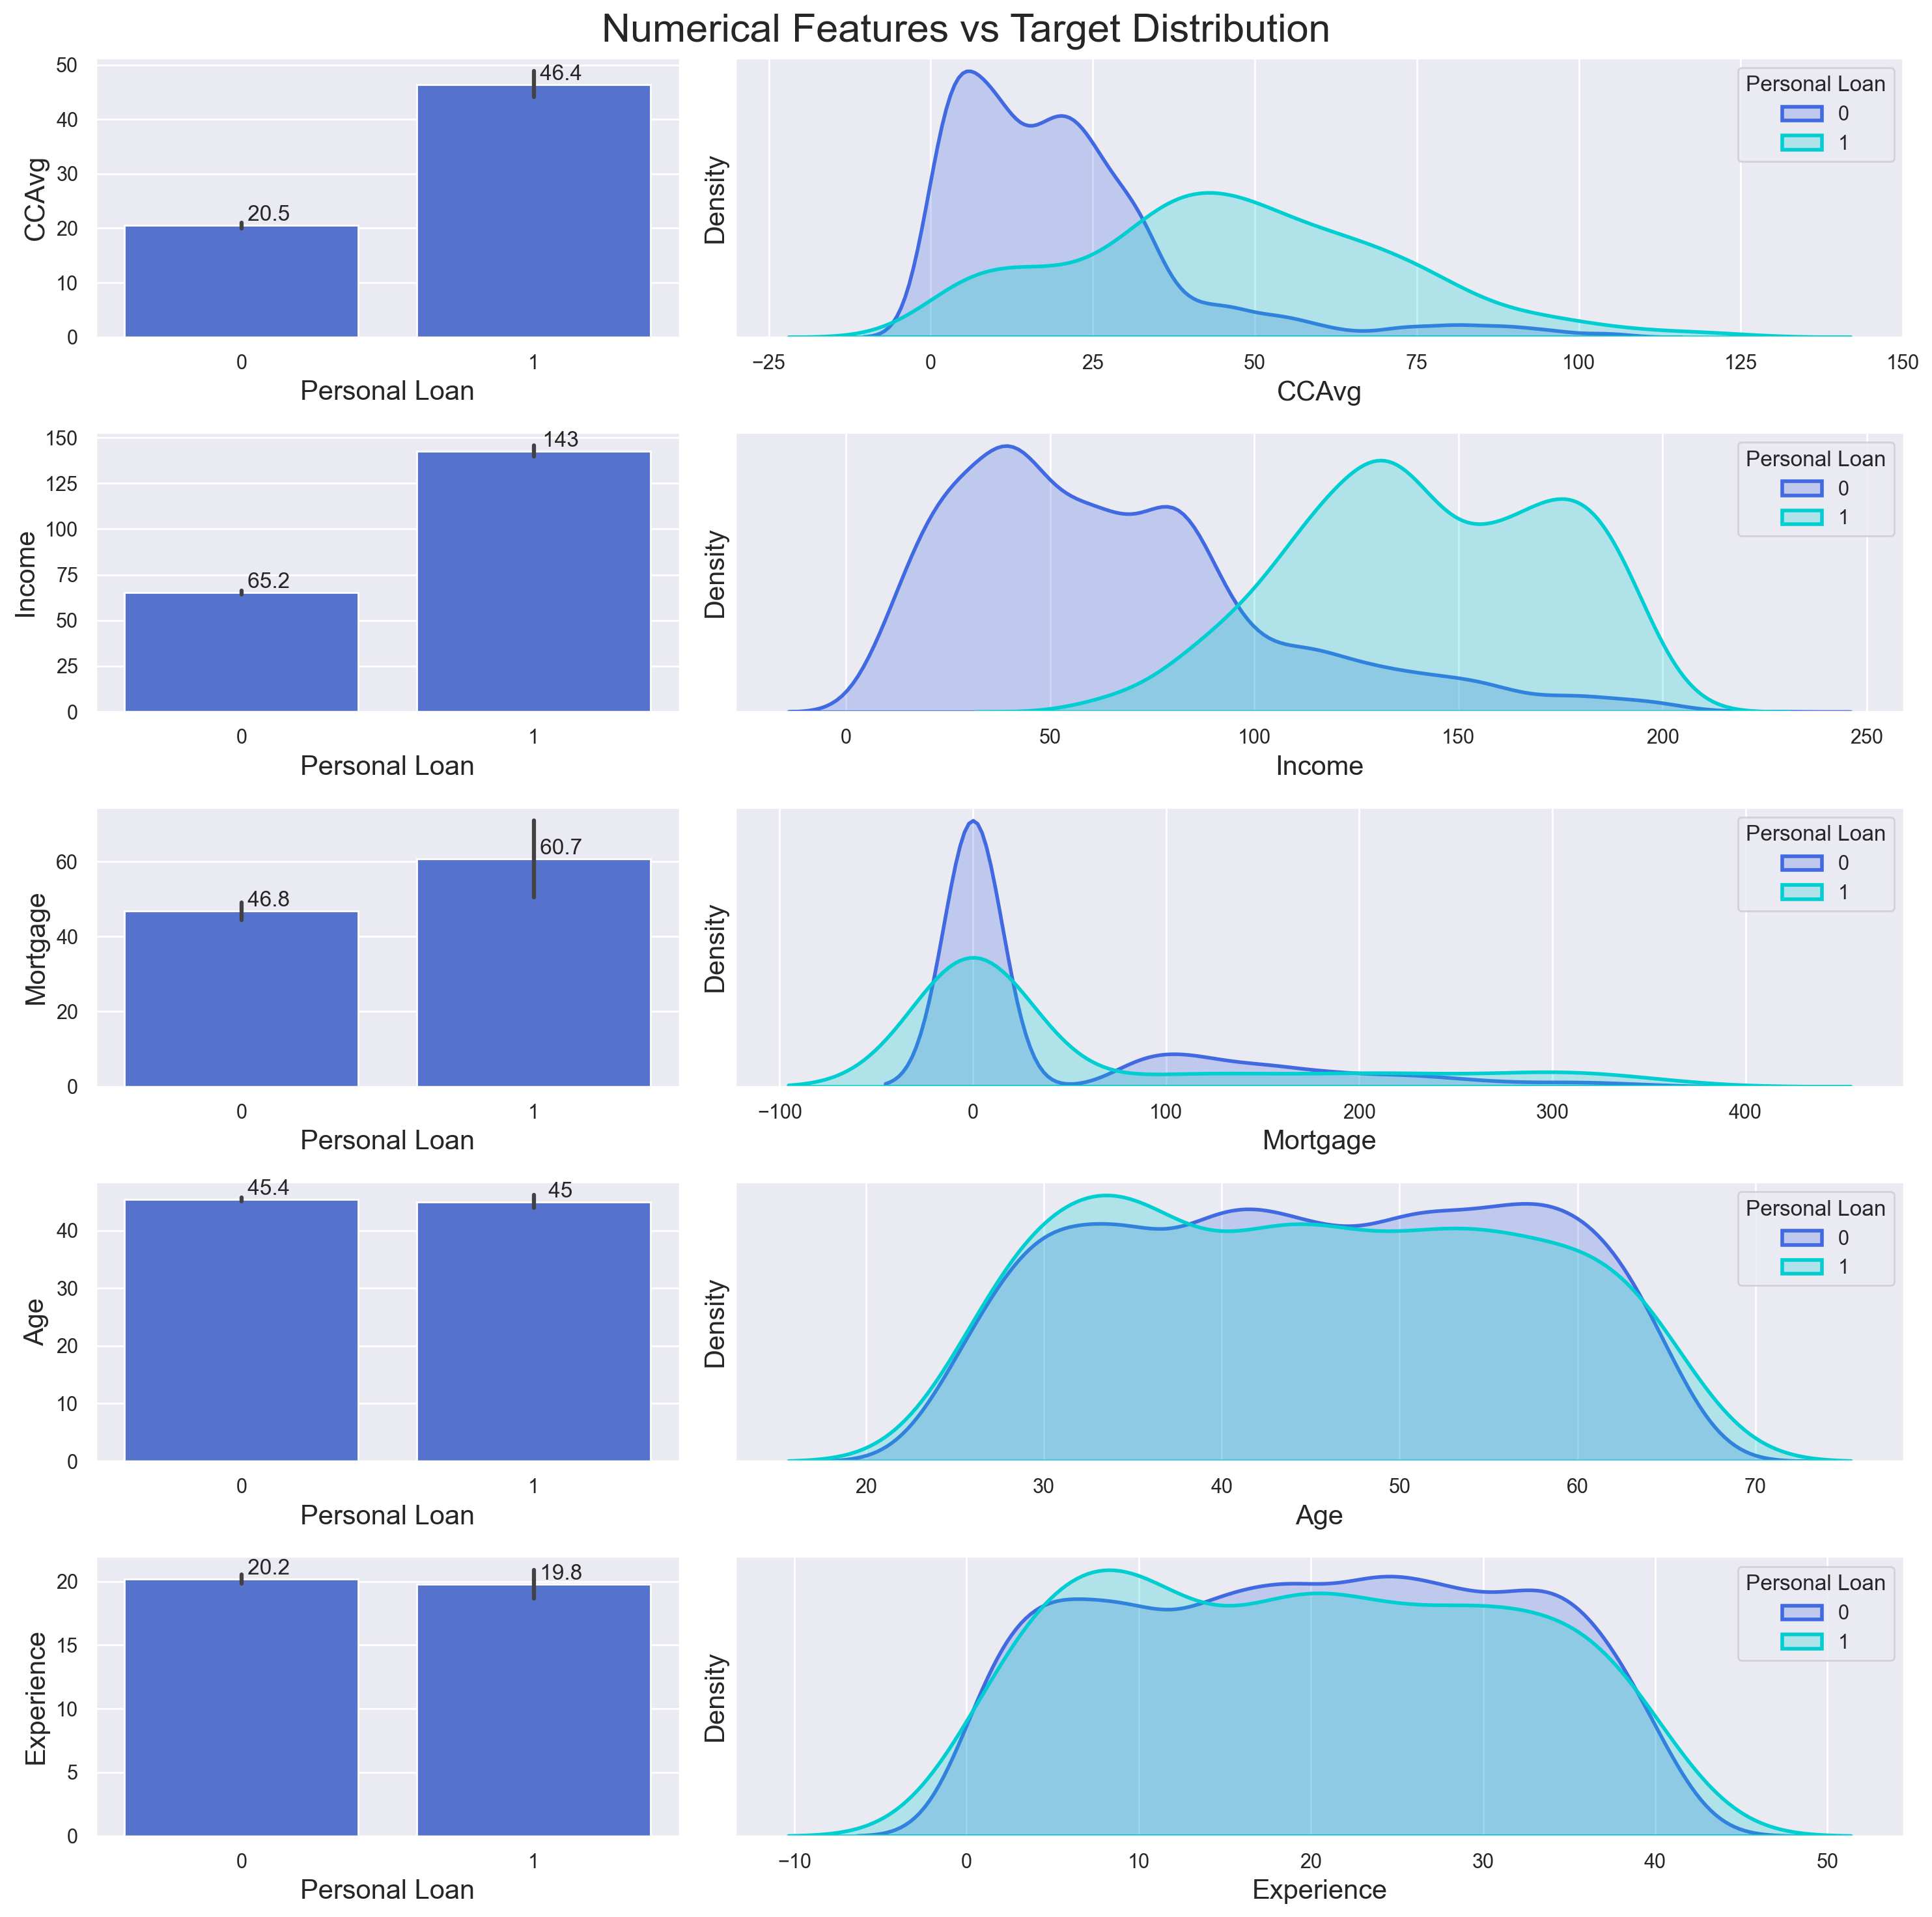

In [22]:
sns.set_palette(['royalblue', 'darkturquoise'])

fig, ax = plt.subplots(5, 2, figsize=(15,15), dpi=200, gridspec_kw={'width_ratios': [1, 2]})

for i,col in enumerate(Num_Features):
    # barplot
    graph = sns.barplot(data=df, x=Target, y=col, ax=ax[i,0])
    # kde Plot
    sns.kdeplot(data=df[df[Target]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df[Target]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Personal Loan', loc='upper right')
    # Add bar sizes to our plot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
plt.suptitle('Numerical Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

<h4 align="left"><font color='lightblue'>Conclusion:</font></h4>

* Customers who spend more on credit cards are more likely to take out personal loans.

* Customers with high incomes are more likely to purchase a personal loan.

* Customers with a high mortgage value are more likely to purchase personal loans.

* It can be inferred that the age of customers has no influence on the probability of purchasing personal loans.

* The effect of the amount of work experience on the purchase of a loan is similar to that of the age of the customer. The distribution of the Experience is very similar to the distribution of Age, as Experience is strongly correlated with Age.

>Therefore, we remove Experience because it doesn't provide any more information than Age:

In [23]:
df.drop('Experience', axis=1, inplace=True)

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 7: Train Test Split</p>

First of all, it is necessary to define the __features (X)__ and the output __labels (y)__ of the given dataset. X is a dataframe containing the different feature values for all given observations, while y is a series containing the categorical labels belonging to each observation:

In [24]:
X = df.drop('Personal Loan', axis=1)
y = df['Personal Loan'] 

We need to perform __train test split__ in supervised machine learning to evaluate the performance of a model after it has been trained. The data set is typically divided into two parts; the training set which is used to train the model, and the test set which is used to measure how well the model performs on new data. Train test split allows us to assess the generalization power of the model by checking its performance on unseen data. This technique can be used to identify any bias and variance in the model and ensure that it generalizes well on unseen examples.

____
<h2 align="left"><font color='lightblue'>Imbalanced dataset:</font></h2>

Imbalanced dataset is a dataset where the classes are not balanced or equal. This means there are an unequal number of samples from each target class and some classes may have significantly more samples than others. 

As we saw in the 3d step, the dataset we are working on is an imbalanced dataset. Let's check it again:

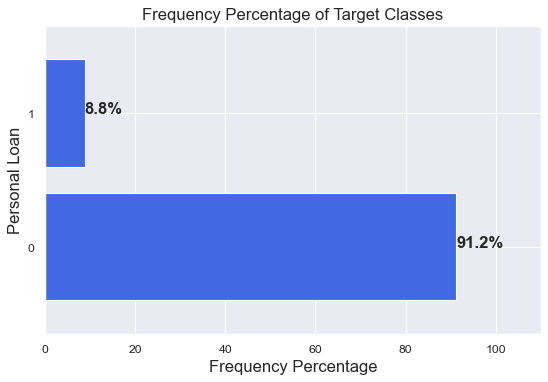

In [25]:
plt.figure(dpi=80)

# Plot frequency percentages barplot
df['Personal Loan'].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

# Add frequency percentages to the plot
labels = df['Personal Loan'].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=15)
plt.ylabel('Personal Loan', fontsize=15)
plt.title('Frequency Percentage of Target Classes', fontsize=15)
plt.show()

As can be seen, __the dataset we are working on is imbalanced.__

____
<h2 align="left"><font color='lightblue'>Problems with Imbalanced Datasets:</font></h2>

1. Imbalanced datasets can lead to algorithms that are biased towards the majority class. This means that any classification algorithm trained on an imbalanced dataset will often inaccurately classify minority classes as the majority class.


2. The performance of a machine learning model can become highly skewed when it is fed with imbalanced data. For example, our dataset has 91.2% class 0 and 8.8% class 1, then the learning model could be easily optimized to just predict all test input as belonging to class 0 and still get 91.2% accuracy!


3. If a model is trained on data which is heavily imbalanced, it can develop an incorrect understanding of the underlying trends in the data. The model may not be able to recognize how certain values are distributed among different classes or even how certain classes overlap with each other.

____
<h2 align="left"><font color='lightblue'>Techniques to Handle Imbalanced Dataset:</font></h2>

<h3 align="left"><font color='royalblue'>1. The approach to train test split:</font></h3>

The approach to train test split when dealing with __imbalanced datasets__ is to use __stratification__. Stratification is an important step in splitting imbalanced datasets into training and test sets. Stratification ensures that the proportion of each class remains the same across both the training and test sets. This is important as it allows for a more accurate evaluation of the model, avoiding bias due to a disproportion of one class being over-represented in either dataset. Stratified sampling also ensures that any trends or correlations among different classes that exist within the overall dataset are preserved after splitting into training and test datasets:

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Let's see the proportion of each class across both the training and test sets:

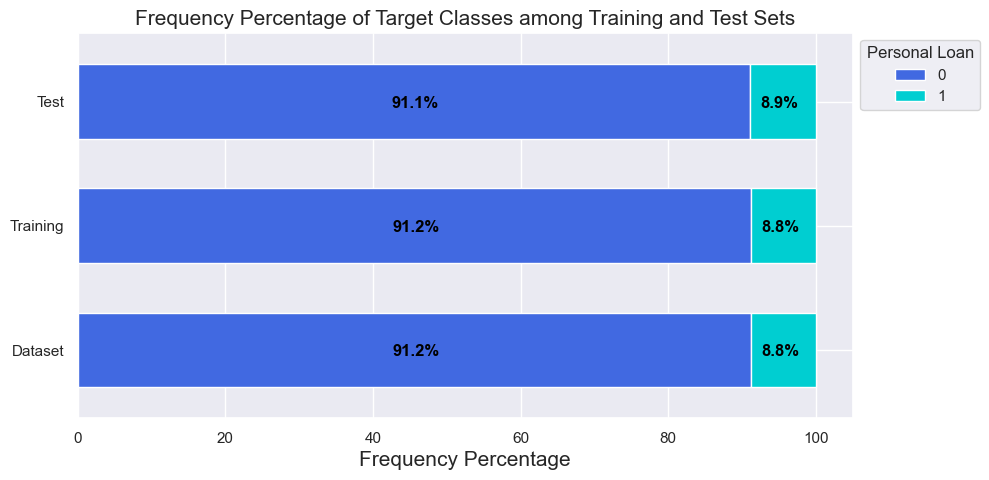

In [27]:
# Define a dataframe containing frequency percentages
df_perc = pd.concat([y.value_counts(normalize=True).mul(100).round(1),
                     y_train.value_counts(normalize=True).mul(100).round(1),
                     y_test.value_counts(normalize=True).mul(100).round(1)], axis=1)
df_perc.columns=['Dataset','Training','Test']
df_perc = df_perc.T

# Plot frequency percentages barplot
df_perc.plot(kind='barh', stacked=True, figsize=(10,5), width=0.6)

# Add the percentages to our plot
for idx, val in enumerate([*df_perc.index.values]):
    for (percentage, y_location) in zip(df_perc.loc[val], df_perc.loc[val].cumsum()):
        plt.text(x=(y_location - percentage) + (percentage / 2)-3,
                 y=idx - 0.05,
                 s=f'{percentage}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")

plt.legend(title='Personal Loan', loc=(1.01,0.8))
plt.xlabel('Frequency Percentage', fontsize=15)
plt.title('Frequency Percentage of Target Classes among Training and Test Sets', fontsize=15)
plt.show()            

As seen, the samples are randomly divided in such a way that the proportion of each class remains the same across both the training and test sets. 

<h3 align="left"><font color='royalblue'>2. The approach for model evaluation:</font></h3>

The approach for __model evaluation__ when dealing with __imbalanced datasets__ is to use appropriate metrics including __recall, precision, F1 score and AUC(area under curve)__ that are better suited when dealing with imbalanced datasets instead of traditional accuracy metrics which don’t take into account class imbalance by default.

In this project, the main goal is to classify potential customers who are more likely to purchase a loan. The metrics used to evaluate the performance of the model will be important in determining how well the model is able to identify these potential customers.

* Recall is a measure of the proportion of actual positive cases that were correctly identified by the model. A high recall score means that the model has a low number of false negatives, which is desirable in this project because it means that the model is not missing many potential loan customers.

* Precision is a measure of the proportion of positive cases identified by the model that are actually positive. A high precision score means that the model has a low number of false positives, which is desirable in this project because it means that the model is not identifying many non-loan customers as potential loan customers.

* F1-score is a measure of the trade-off between recall and precision. It is calculated as the harmonic mean of recall and precision. A high F1-score indicates a balance between high recall and high precision.

__For this project, both recall and precision for class '1' are important metrics, so f1-score for class '1' should be considered as the most important metric. A high f1-score indicates a balance between identifying as many potential loan customers as possible (high recall) and minimizing the number of false positives (high precision). This is important for the bank, as it wants to increase the conversion rate of depositors to borrowers while reducing the cost of the marketing campaign.__

<h3 align="left"><font color='royalblue'>3. Approaches for model building:</font></h3>

> <h3 align="left"><font color='lightblue'>I) Data-based approaches:</font></h3>
>
>* __Random undersampling__: Undersampling involves randomly removing instances from the majority class to reduce its size.
>    * __Cons__: Information loss caused by discarding the majority of the training set.
>
>
>* __Random oversampling__: It involves adding additional copies of instances from the minority class to make it more equal in size.
>    * __Cons__: Overfitting, which is caused by replicating observations from the minority class.
> 
>
>* __SMOTE__: SMOTE (Synthetic Minority Oversampling Technique) is an oversampling technique that creates new, synthetic observations from the minority class. This way, the algorithm avoids the problem of overfitting encountered with random oversampling.
>
>    * __Cons__: Since SMOTE randomly creates rows of new data, the newly created synthetic samples lack real value information, thus leading to a potential decrease in accuracy overall. In addition, if there are natural boundaries between classes such as overlapping classes, additional outliers may be created due to the artificial creation of data points through SMOTE.

> <h3 align="left"><font color='lightblue'>II) Model-based approaches:</font></h3>
>
> * __Penalize Algorithms__: Penalize algorithms by giving more weight to a specific classification label, making correct classification of the minority class more important than correct classification of the majority class during optimisation process.
>
>
> * __Use Tree-Based Algorithms__: Tree-based algorithms like Random Forest, Extra Trees Classifiers and XGBoost can naturally handle imbalanced data because they make decisions based on a majority vote among randomized decision trees and do not require balancing classes before training.


Considering the disadvantages of data-based methods, we will just implement model-based approaches.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 8: Feature Selection</p>

__Feature selection__ is the process of selecting a subset of relevant features for use in model building.

<h2 align="left"><font color='lightblue'>Advantages of Feature Selection:</font></h2>

1. __Enhanced Accuracy__: When there are fewer features, the model has fewer potential aspects to learn, which may lead to fewer errors being made when predicting new data.

2. __Improved Interpretability__: Feature selection helps to identify important features and also make a model more interpretable by removing redundant or irrelevant features from the data set.

3. __Faster Training Time__: Feature selection reduces the computational cost by reducing the number of computations that need to be performed in order to train and test the model. This, in turn, reduces training time and makes models more efficient.

4. __Reduced Overfitting__: By removing irrelevant and redundant features from data, feature selection can also help in reducing overfitting which can occur when too many variables are included in a model without sufficient observations or regularization techniques applied.

____
<h2 align="left"><font color='lightblue'>Feature Selection Methods:</font></h2>

> <h3 align="left"><font color='royalblue'>I) Wrapper Methods:</font></h3> 
> These methods use a predictive model to score each subset of features and determine the importance of each feature. Most important wrapper methods are: 
>
> * __Forward Selection:__ Forward Selection is an iterative feature selection method that starts off with no features in the model and one by one adds the most predictive feature to the model, stopping when there is no improvement on a validation score. This process is repeated until certain criteria are met or all possible sets of features have been considered. By using a metric , the algorithm can identify which combinations of features best improve model performance. The result of Forward Selection is an ordered list that ranks the importance of each feature according to its contribution to improving model accuracy.
>
>
> * __Permutation:__ Permutation evaluates the influence of a given feature by shuffling its values and thereby creating a random permutation, measuring how much the model accuracy drops as consequence. The greater the drop in accuracy, the more important this feature proved to be for solving the task at hand.
>
>
> * __Drop-column:__ The idea is to calculate the model performance with all predictors and drop a single predictor and see the reduction in the performance. The more important the feature is, the larger the decrease we see in the model performance.


> <h3 align="left"><font color='royalblue'>II) Filter Methods:</font></h3> 
> These methods use statistical measures such as:
>
> * __Correlation Coefficients__
> * __Information Gain__
> * __Chi-square Test__


> <h3 align="left"><font color='royalblue'>III) Embedded Methods:</font></h3> 
> Embedded methods combine elements of both filter and wrapper approaches by constructing predictive models during the feature selection process in order to better evaluate potential features. Examples of embedded methods include: 
>
> * __LASSO Regression__
> * __Decision Trees__
> * __Random Forest__
> * __Gradient Boosting Machines (GBM)__

We will continue to use __Drop-column Feature Importance__ method as it is actually __the most accurate way__ to calculate the feature importances.

__Note__: Drop-column method does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for __a particular model__. 

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 8.1: Drop-column Feature Importance Implementation</p>

As we discussed earlier, f1-score for calss '1' should be considered as the most important metric for this project:

In [28]:
# Define a scorer function
def f1_metric(model, X_train, y_train):
    '''
    This function reports f1-score metric for the class specified by 'Positive Label' (or '1')
    '''
    return f1_score(y_train, model.predict(X_train), average='binary')

__Cloning a model__ can be useful for creating multiple versions of the same model. This way, different versions of the model can be tested with various parameters or datasets. This can allow for more thorough and accurate evaluation of the model so that one version is not overly biased towards previous versions. Additionally it may be desirable to find out how slightly different parameters affect the performance of a model. Cloning a model allows us to do this quickly and easily by generating multiple models and testing them side-by-side. 

Next, we will implement Drop-column Feature Importance Technique through a function using cloning:

In [29]:
def drop_column_importance(model, X_train, y_train, random_state=0):
    # list containing feature importances
    importances = []
    # Clone the model
    model_clone = clone(model)
    # Set random_state for comparability
    model_clone.random_state = random_state
    # Train the model
    model_clone.fit(X_train, y_train)
    # Create the cross-validation object using StratifiedKFold 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    # Score the benchmark model using cross-validation
    benchmark_score = cross_val_score(model_clone, X_train, y_train, cv=cv, scoring=f1_metric).mean()

    
    # Iterate over all features and store feature importance
    for col in X_train.columns:
        # Clone the model
        model_clone = clone(model)
        # Set random_state for comparability
        model_clone.random_state = random_state
        # Traint the model on the the dataset with a single feature removed
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        # Score the droped-column model
        drop_column_score = cross_val_score(model_clone, X_train.drop(col,axis=1), y_train, cv=cv, scoring=f1_metric).mean()
        # Store feature importance which is defined as the difference between the benchmark and the new model score
        importances.append(benchmark_score - drop_column_score)
        
    # Return the features along with their importances in the form of a dataframe
    importances_df = pd.DataFrame({'feature': X_train.columns, 'feature importance': importances}) \
                     .sort_values('feature importance', ascending = False).reset_index(drop = True)
           
    return importances_df                  

Define a function to __visualize__ the results of Drop-column Feature Importance technique using bar charts:

In [30]:
def drop_column_importance_plot(model, X_train, y_train):
    # Call drop-column feature importance function
    df_drop_column = drop_column_importance(model, X_train, y_train, random_state=0)
    # Rename columns
    df_drop_column.columns = ['Feature', 'Feature Importance']
    
    # Plot barchart
    plt.figure(figsize=(12,10))
    sns.barplot(data=df_drop_column, x='Feature Importance', y='Feature', orient='h', color='royalblue')
    plt.title('Drop Column Feature Importance', fontsize=20)
    plt.show()

In the next steps, we will use these functions before building our final model regarding each classification algorithm to detect redundant features.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 9: Naive Bayes Model Building</p>

__Naive Bayes__ is a __classification__ algorithm in machine learning. It is used to predict the probability of a given input belonging to different classes or categories. It is based on Bayes' theorem, which uses the prior probability of the class and the likelihood of the features given the class to calculate the posterior probability of the class. The class with the highest posterior probability is then chosen as the predicted class for the input. The Naive Bayes classifier algorithm makes several assumptions about the data and the problem it is being used to solve.

<h2 align="left"><font color='lightblue'>Naive Bayes Main Assumptions:</font></h2>

1. __Independence:__ The algorithm assumes that all the features in the data are independent of each other given the class. This is the "naive" part of the algorithm and is often unrealistic in real-world problems, but it allows for a computationally efficient solution.

2. __Conditional independence:__ The algorithm also assumes that the features are conditionally independent, meaning that the probability of a feature given the class is independent of the other features.

3. __Constant class prior:__ The algorithm assumes that the class prior probabilities are constant and do not change with the data.

__Note:__ The Naive Bayes basic assumptions have been satisfied since only two features were highly correlated, Experience and Age, and the Experience feature had been removed earlier.

_____
<h2 align="left"><font color='lightblue'>Different types of Naive Bayes algorithms available in sklearn:</font></h2>

* __Gaussian Naive Bayes:__ This algorithm is used when the data is continuous and follows a __normal__ distribution.

* __Multinomial Naive Bayes:__ This algorithm is used when the data is discrete and represents the __count of occurrences__ of each category.

* __Bernoulli Naive Bayes:__ This algorithm is similar to the multinomial Naive Bayes, but it is used when the data is __binary__. 

* __Complement Naive Bayes:__ This algorithm is similar to the Multinomial Naive Bayes, but it is designed for __imbalanced data sets__. 

* __Categorical Naive Bayes:__ This algorithm is similar to the Multinomial Naive Bayes, but it is designed for __categorical data, rather than count data__. 


In this project, our dataset contains a mixture of features with different distributions:
* Continuous Features - Age, Income, CCAvg, Mortgage
* Binary Features - Securities Account, CD Account, Online, CreditCard
* Multinomial Features - Family
* Categorical Features - Education, ZIP Code

> <h3 align="left"><font color='lightblue'>Strategies:</font></h3> 
>
> * __First strategy__ is to independently fit a Gaussian NB model on the continuous part of the data, a Complement NB model (imbalanced dataset) on the multinomial part of the data, a Bernoulli model on the bernoulli part of the data and a Categorical NB on the categorical part of the data. After fitting each model on the corresponding part of the dataset, then we actually transform the dataset by taking the class assignment probabilities (using predict_proba method) as new features and then refit a new Gaussian NB model on the new features.
>
> * __Second strategy__ is to discretize continuous features and apply different discrete-data based Naive Bayes models, including Complement NB, and Bernoulli NB, in order to find the model with the best performance.


>We will implement the __second strategy__ because Income, CCAvg, and Mortgage are continuous features that are important features according to step 6.2, but their distribution is not normal and has high skewness and kurtosis, which causes a large error when performing Gaussian NB.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 9.1: Complement NB Model Building</p>

__Multinomial NB__ is a probabilistic classifier that is commonly used in text classification tasks. It is based on the assumption that the features (e.g. words) in the text are conditionally independent given the class label. Multinomial NB models the probability of each feature given a class label using a multinomial distribution. 

__Complement NB__ is a variant of Multinomial NB algorithm that is designed to correct for the bias that is inherent in Multinomial NB algorithm. Multinomial NB algorithm tends to assign higher probability to classes that have more training samples. Complement NB aims to correct for this bias by computing the complement of the standard Naive Bayes probability estimates and then using these complement probabilities to make predictions. 

Since our dataset is imbalanced, we will use CNB instead of MNB.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:70%; color:white; text-align:center; border-radius:10px 10px; padding:6px">Step 9.1.1: Complement NB Feature Discretization</p>

__KBinsDiscretizer__ class from scikit-learn provides an implementation of discretization using the binning method. It allows us to choose between different number of bins (n_bins) and strategies for binning. 

We will define a function containing __GridSearchCV__ class to find the best combination of __n_bins__ and __strategy__. In other words, we try all combinations of n_bins and strategy within the defined range and use the considered NB model to evaluate the discretizer's performance on the validation set in order to find the optimal combination:

In [31]:
def discretization_report(df, clf):
    '''
    This function finds the optimal combination of n_bins and strategy for continuous features discretization
    '''
    # Define continuous features to perform discretization on
    cols_to_discretize = ['Age', 'Income', 'CCAvg', 'Mortgage']

    # Define the features (X) and the output labels (y) 
    X = df[cols_to_discretize]
    y = df['Personal Loan']

    # Split dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    # Define the grid search parameters
    param_grid = {'discretizer__strategy': ['uniform', 'quantile', 'kmeans'],
                  'discretizer__n_bins': np.arange(2,11)}

    # Define the KBinsDiscretizer and OneHotEncoder and ComplementNB objects
    discretizer = KBinsDiscretizer(encode='ordinal')
    onehot = OneHotEncoder(handle_unknown='ignore', drop='first')

    # Create the pipeline
    pipeline = Pipeline([('discretizer', discretizer), ('onehot', onehot), ('clf', clf)])

    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1')
    
    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and the best score
    print("Best discretization parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    
    # Return optimal values for n_bins and strategy
    return grid_search.best_params_['discretizer__n_bins'], grid_search.best_params_['discretizer__strategy']

Find optimal values for KBinsDiscretizer parameters using discretization_report function:

In [32]:
# Ignore a warning that in some cases, the width of the bins will be too small
warnings.simplefilter(action='ignore')

# Initialize the CNB classifier
cnb = ComplementNB()

# Call discretization_report
n_bins, strategy = discretization_report(df, cnb)

  File "C:\Users\parha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 245, in _count_physical_cores
    raise ValueError(


Best discretization parameters: {'discretizer__n_bins': 6, 'discretizer__strategy': 'quantile'}
Best score: 0.5354708442834474


The optimal values obtained for n_bins and strategy considering the CNB model are:
* n_bins : 6
* strategy : quantile (All bins in each feature have the same number of points)

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:70%; color:white; text-align:center; border-radius:10px 10px; padding:6px">Step 9.1.2: Complement NB Feature Encoding</p>

After obtaining the optimal values for KBinsDiscretizer arguments including n_bins and strategy, we discretize continuous features with these optimal arguments. Then, we implement dummy encoding on non-binary categorical features. We define a function for feature encoding: 

In [33]:
def nb_feature_encoding(df, n_bins, strategy, cols_to_encode):
    '''
    This function performs dummy encoding on the desired categorical features after performing feature discretization 
    considering optimal n_bins and strategy values.
    '''
    # Define continuous features to perform discretization on
    cols_to_discretize = ['Age', 'Income', 'CCAvg', 'Mortgage']

    # Define the features (X) and the output labels (y) 
    X = df.drop('Personal Loan', axis=1)
    y = df['Personal Loan'] 

    # Split dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    # Discretize the continuous features
    discretizer = KBinsDiscretizer(n_bins=n_bins, strategy=strategy, encode='ordinal')
    X_train[cols_to_discretize] = discretizer.fit_transform(X_train[cols_to_discretize])
    X_test[cols_to_discretize] = discretizer.transform(X_test[cols_to_discretize])

    # Onehot encode the discretized features
    X_train = pd.get_dummies(X_train, columns=cols_to_encode, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=cols_to_encode, drop_first=True)
    
    # Align the columns of the test set with the training set
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
    
    # Return transformed features
    return X_train, X_test

Applying onehot encoding on the desired features using nb_feature_encoding function:

In [34]:
# All non-binary features are selected for onehot encoding
cols_to_encode = ['Age', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education']

# Call nb_feature_encoding
X_train, X_test = nb_feature_encoding(df, n_bins, strategy, cols_to_encode)

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:70%; color:white; text-align:center; border-radius:10px 10px; padding:6px">Step 9.1.3: Complement NB Feature Subset Selection</p>

To find the most important features considering CNB model, we use the drop_column_importance_plot function we defined earlier:

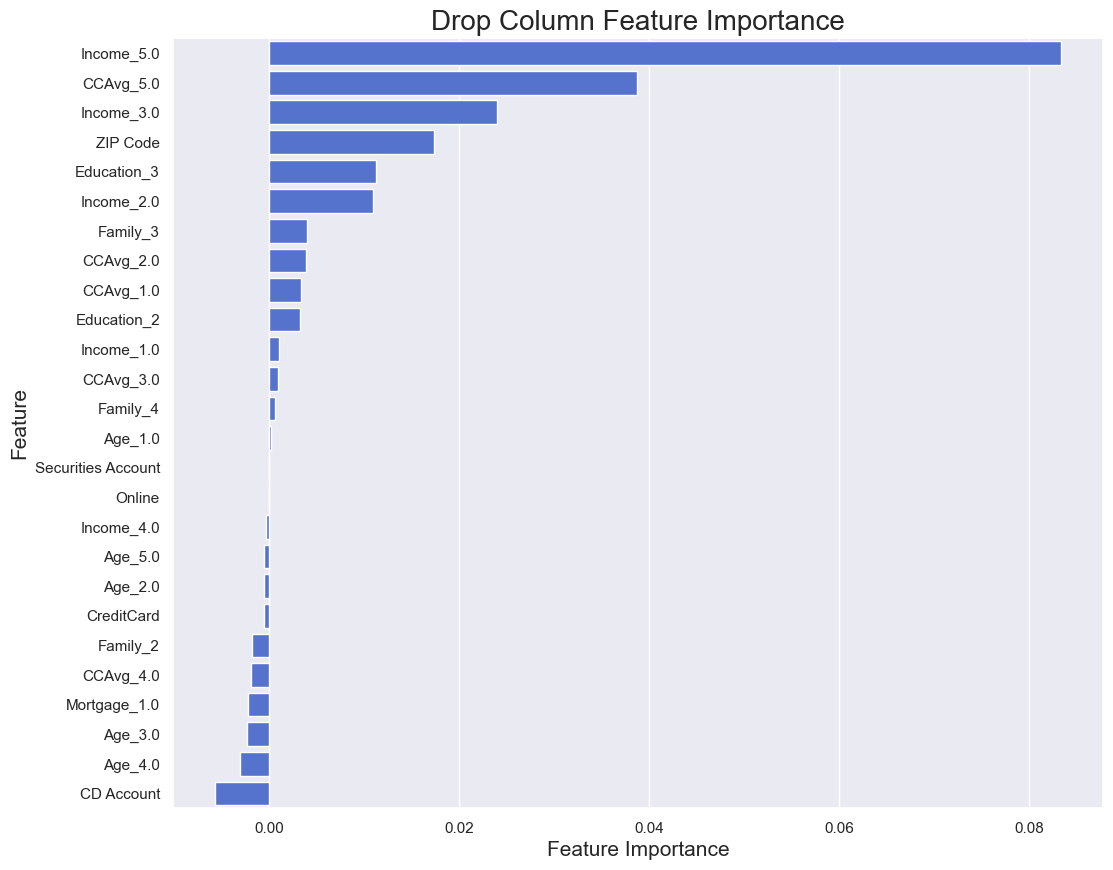

In [35]:
# Initialize the CNB classifier
cnb = ComplementNB()

# Call drop_column_importance_plot
drop_column_importance_plot(cnb, X_train, y_train)

Negative importance in Drop-column Feature Importance means that removing the corresponding feature from the model actually improves the model performance. So we filter our dataset:

In [36]:
feature_importances = drop_column_importance(cnb, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0]['feature']

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:70%; color:white; text-align:center; border-radius:10px 10px; padding:6px">Step 9.1.4: Complement NB Model Building</p>

After removing irrelevant features, we train the final CNB model:

In [37]:
cnb = ComplementNB()
cnb.fit(X_train, y_train)

ComplementNB()

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:70%; color:white; text-align:center; border-radius:10px 10px; padding:6px">Step 9.1.5: Complement NB Model Evaluation</p>

To evaluate the performance of the model, we define a function so that it can be used to evaluate subsequent models as well:

In [38]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='binary'),
                                recall_score(y_test, y_pred, average='binary'),
                                f1_score(y_test, y_pred, average='binary'),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[::,1])],
                          index=['Accuracy','Precision','Recall','F1-score','AUC'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [39]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show() 

Let's call the above function for evaluating our CNB model:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      3569
           1       0.41      0.95      0.57       346

    accuracy                           0.88      3915
   macro avg       0.70      0.91      0.75      3915
weighted avg       0.94      0.88      0.90      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.85      0.92       892
           1       0.38      0.94      0.54        87

    accuracy                           0.86       979
   macro avg       0.69      0.90      0.73       979
weighted avg       0.94      0.86      0.88       979



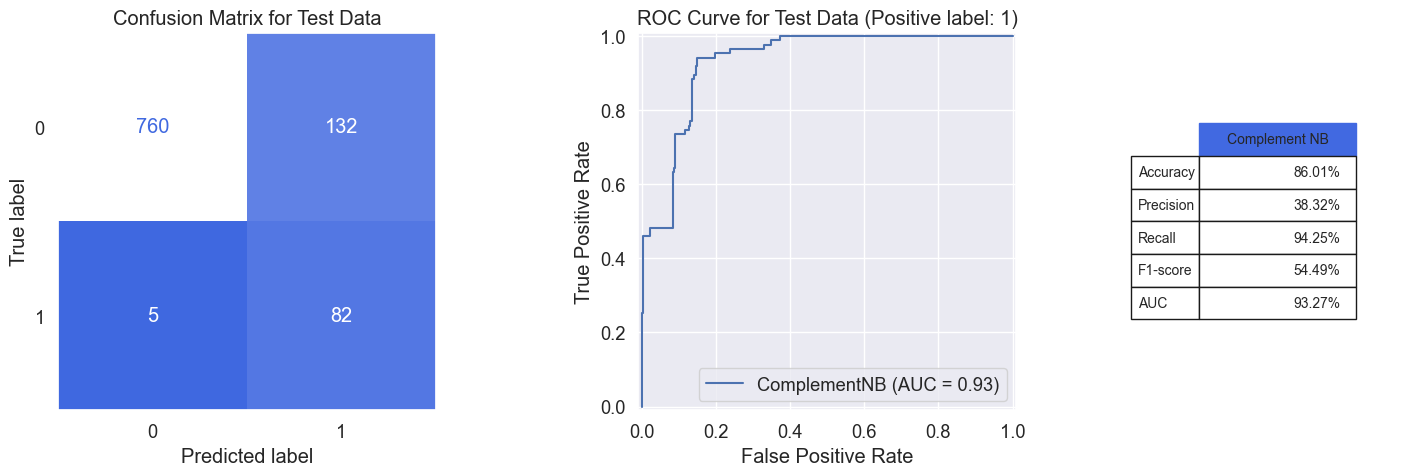

In [40]:
model_evaluation(cnb, X_train, X_test, y_train, y_test, 'Complement NB')

We got a recall score of about 94% from Complement NB, which is good, but due to the low precision value of 38%, the f1-score is about 54%.

In [41]:
# Save the final performance of Complement Naive Bayes classifier
cnb_result = metrics_calculator(cnb, X_test, y_test, 'Complement Naive Bayes')

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 9.2: Bernoulli NB Model Building</p>

__Bernoulli NB__, like MultinomialNB, is suitable for discrete data. The difference is that while MultinomialNB works with occurrence counts, BernoulliNB is designed to work with binary data, where the features are either true or false (1 or 0).

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:70%; color:white; text-align:center; border-radius:10px 10px; padding:6px">Step 9.2.1: Bernoulli NB Feature Discretization</p>

To find the optimal values for KBinsDiscretizer considering Bernoulli NB, we call discretization_report function:

In [42]:
# Initialize the Categorical NB classifier
bnb = BernoulliNB()

# Call discretization_report
n_bins, strategy = discretization_report(df, bnb)

Best discretization parameters: {'discretizer__n_bins': 9, 'discretizer__strategy': 'uniform'}
Best score: 0.5184448691429347


The optimal values obtained for n_bins and strategy considering the BNB model are:
* n_bins : 9
* strategy : uniform (All bins in each feature have identical widths)

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:70%; color:white; text-align:center; border-radius:10px 10px; padding:6px">Step 9.2.2: Bernoulli NB Feature Encoding</p>

Now, we discretize continuous features with the obtained optimal n_bins and strategy. Then, we need to implement dummy encoding on all non-binary features. 

Since the ZIP Code feature contains a large number of categories and is not an important feature, we will remove it for Bernoulli NB modeling:

In [43]:
df_bnb = df.copy()
df_bnb.drop('ZIP Code', axis=1, inplace=True)

Applying onehot encoding on all non-binary features using nb_feature_encoding function:

In [44]:
# All non-binary features are selected for onehot encoding
cols_to_encode = ['Age', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education']

# Call nb_feature_encoding
X_train, X_test = nb_feature_encoding(df_bnb, n_bins, strategy, cols_to_encode)

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:70%; color:white; text-align:center; border-radius:10px 10px; padding:6px">Step 9.2.3: Bernoulli NB Feature Subset Selection</p>

To find the most important features considering BNB model, we again use the drop_column_importance_plot function we defined earlier:

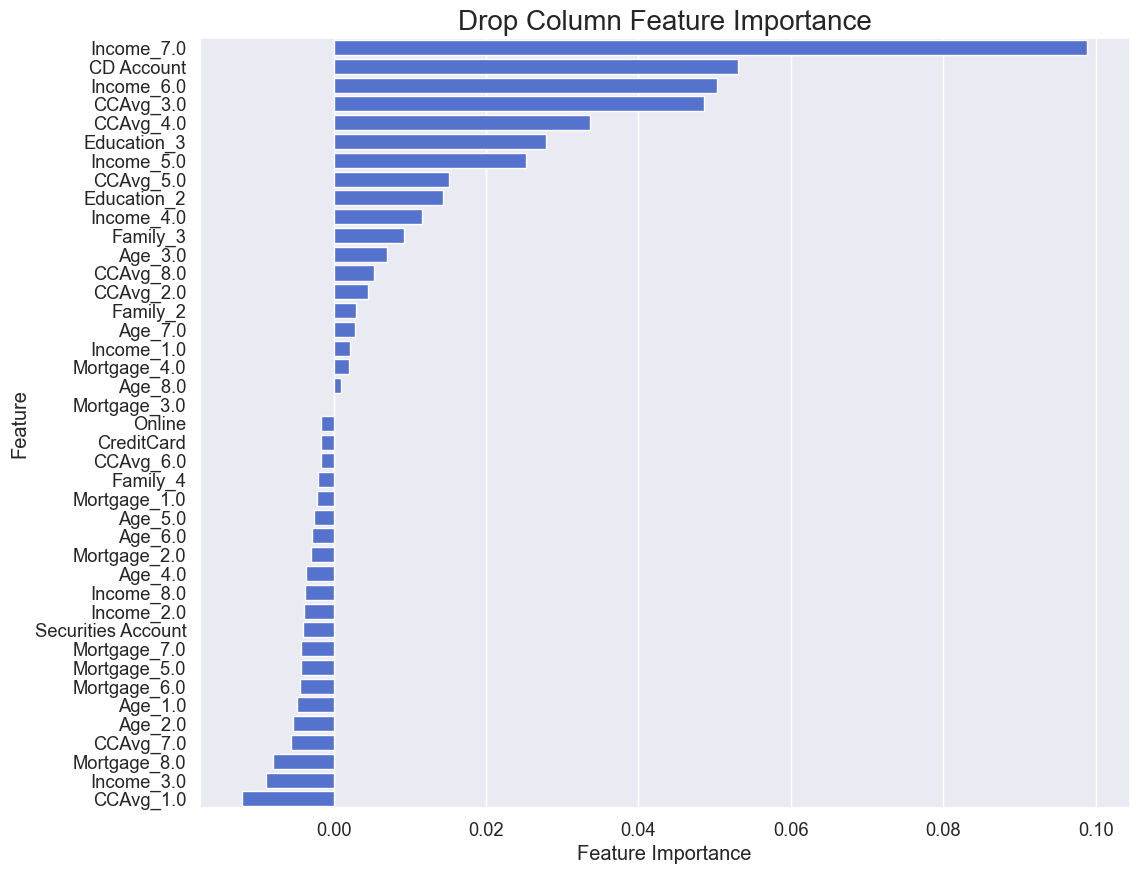

In [45]:
# Initialize the BNB classifier
bnb = BernoulliNB()

# Call drop_column_importance_plot
drop_column_importance_plot(bnb, X_train, y_train)

Again negative importance in Drop-column Feature Importance means that removing the corresponding feature from the model actually improves the model performance. So we filter our dataset:

In [46]:
# Find Important features with positive feature_importance value
feature_importances = drop_column_importance(bnb, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0]['feature']

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:70%; color:white; text-align:center; border-radius:10px 10px; padding:6px">Step 9.2.4: Bernoulli NB Model Building</p>

After removing irrelevant features, we train the final BNB model:

In [47]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

BernoulliNB()

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:70%; color:white; text-align:center; border-radius:10px 10px; padding:6px">Step 9.2.5: Bernoulli NB Model Evaluation</p>

Evaluate our trained Bernoulli NB model performance using model_evaluation function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3569
           1       0.73      0.55      0.63       346

    accuracy                           0.94      3915
   macro avg       0.85      0.77      0.80      3915
weighted avg       0.94      0.94      0.94      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       892
           1       0.72      0.51      0.59        87

    accuracy                           0.94       979
   macro avg       0.84      0.74      0.78       979
weighted avg       0.93      0.94      0.93       979



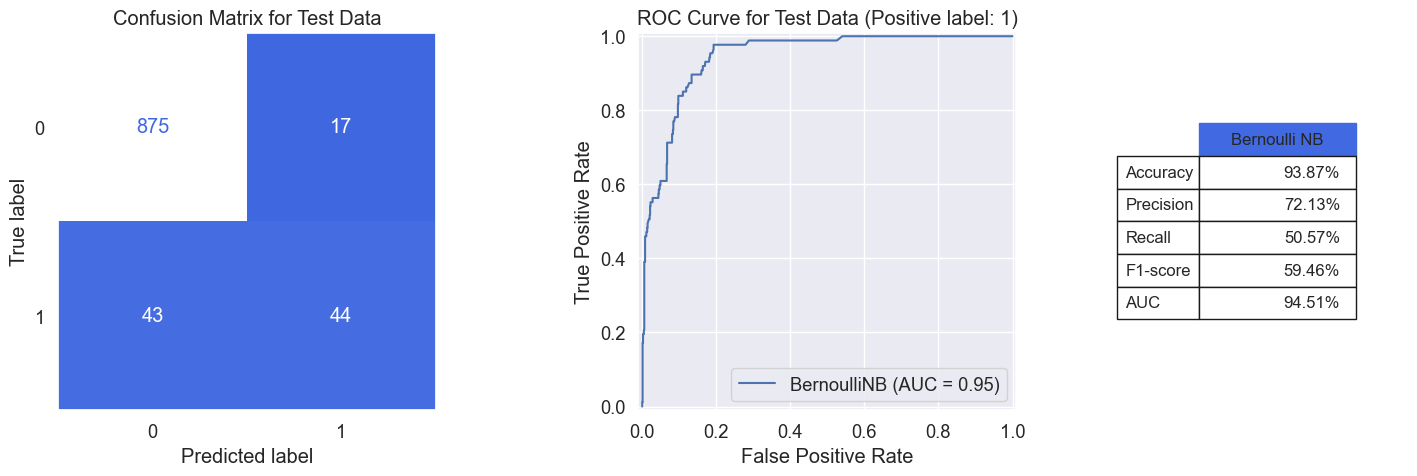

In [48]:
model_evaluation(bnb, X_train, X_test, y_train, y_test, 'Bernoulli NB')

We got a 5% increase in f1-score compared to Complement NB model. In the Bernoulli NB model, compared to Complement NB, the value of precision has increased, while the value of recall has decreased. AUC value did not differ.

In [49]:
# Save the final performance of Bernoulli Naive Bayes classifier
bnb_result = metrics_calculator(bnb, X_test, y_test, 'Bernoulli Naive Bayes')

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 10: Logistic Regression Model Building</p>

__Logistic Regression__ is a type of supervised machine learning algorithm used for binary classification problems. It models the probability of a target variable (usually binary) as a function of input features, using a logistic function (sigmoid) to map predictions between 0 and 1. The model is trained using labeled data to optimize the coefficients of the features to minimize the prediction error.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 10.1: Scale Data using Standard Scaler</p>

Before building our logistic classifier, we will apply __Standard Scaler__ to our data.

__Standard Scaler__ is used to scale the data. It transforms the data by subtracting the mean and dividing by the standard deviation, ensuring that all features have a similar range of values.


<h3 align="left"><font color='lightblue'>Benefits of Standard Scaling on Logistic Regression:</font></h3>

1. __Gradient Descent Convergence__: The optimization algorithm used in logistic regression is gradient descent. When the features have different scales, the magnitude of the gradient will also be different for different features. Scaling the features to have the same scale ensures that the magnitude of the gradient is the same for all features, which can lead to faster convergence of the optimization algorithm.


2. __Regularization__: Logistic regression uses regularization to prevent overfitting. When the features have different scales, the regularization term in the cost function tends to give more weight to the features with higher values, which can be problematic in certain cases. Scaling the features to have the same scale can alleviate this issue.


3. __Better Performance__: In some cases, scaling the features can lead to a better performance of the logistic regression model, especially when the features have a skewed distribution or are not on the same scale.

In [50]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [51]:
# Scale the training and test data using the same scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert training and test sets from numpy array to pandas dataframes
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

__Note:__ It is very important that StandardScaler transformation should only be learnt from the training set, otherwise it will lead to data leakage.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 10.2: Logistic Regression Hyperparameter Tuning</p>

__Hyperparameter tuning__ can affect the performance of a logistic regression model by allowing it to find the best combination of hyperparameters that result in the lowest error on the training set. This can lead to improved prediction performance and reduced overfitting. However, if not done, it can lead to overfitting on the validation set, resulting in a model that is not generalizable to new data.

Also, since our dataset is imbalanced, we intend to make the correct classification of the minority class more important than the correct classification of the majority class in the optimization process, which is called __penalizing__ the model. We do this by giving more weight to the minority class. Therefore, the weights of the classes are hyperparameters whose optimal value is also determined during the Hyperparameter tuning process.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:70%; color:white; text-align:center; border-radius:10px 10px; padding:6px">Step 10.2.1: Define the Hyperparameter Grid</p>

Hyperparameter Grid refers to a pre-defined set of hyperparameters to be tested in a model training process. Each combination of hyperparameters is a single point in the grid, and the goal is to select the best hyperparameters for the model by evaluating model performance on a validation set. The grid defines the search space for hyperparameter optimization algorithms to find the optimal hyperparameters.

In Logistic Regression, solver choice is determined by penalty choice. Supported penalties by solvers are:

> * __lbfgs -> [ l2 , None ]__
>
> * __liblinear -> [ l1 , l2 ]__
>
> * __newton-cg -> [ l2 , None ]__
>
> * __sag -> [ l2 , None ]__
>
> * __saga -> [ elasticnet , l1 , l2 , None ]__


Therefore, different combinations of solver and penalty should be considered:

In [52]:
# Weights associated with classes
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,0.5,20)]

# Define hyperparameters grid
param_grid = [{'solver':['lbfgs', 'newton-cg', 'sag', 'saga'], 
               'penalty':['none'], 
               'class_weight':class_weights}, 
              
              {'solver':['lbfgs', 'newton-cg', 'sag'], 
               'penalty':['l2'], 
               'C': np.logspace(-5, 5, 10), 
               'class_weight':class_weights},
              
              {'solver':['liblinear', 'saga'], 
               'penalty': ['l1', 'l2'], 
               'C': np.logspace(-5, 5, 10), 
               'class_weight':class_weights},
              
              {'solver':['saga'], 
               'penalty':['elasticnet'], 
               'C': np.logspace(-5, 5, 10),
               'l1_ratio': np.arange(0,1.1,0.1), 
               'class_weight':class_weights}]    

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:70%; color:white; text-align:center; border-radius:10px 10px; padding:6px">Step 10.2.2: Find the Optimal Hyperparameters</p>

We use GridSearchCV to find the optimal combination of hyperparameters that gives the best performance on the training data:

We will define a function in which the optimal combination of hyperparameters that will cause the best __f1-score__ value for the model will be discovered. For this reason, we define a function so that it can be used to tune the hyperparameters of future models as well:

In [56]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train):
    '''
    This function optimize the hyperparameters for a classifier by searching over a specified hyperparameter grid. It uses 
    GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters, and selects  
    the combination with the highest f1-score. The function returns the best classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=f1_metric, n_jobs=1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    print("Best hyperparameters:\n", clf_grid.best_params_)
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_

We use the above function to find the optimal combination of hyperparameters for logistic regression classifier:

In [57]:
# Define the base model
logreg = LogisticRegression(max_iter=1000)

# Call tune_clf_hyperparameters function to find the optimal combination of hyperparameters 
logreg_opt = tune_clf_hyperparameters(logreg, param_grid, X_train, y_train)

Best hyperparameters:
 {'C': 3.593813663804626, 'class_weight': {0: 0.4474736842105263, 1: 0.5525263157894738}, 'l1_ratio': 0.2, 'penalty': 'elasticnet', 'solver': 'saga'}


These are the optimal hyperparameter values for the Logistic Regression model. logreg_opt is the Logistic Regression model whose hyperparameters have been set to the optimal values.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 10.3: Logistic Regression Feature Subset Selection</p>

Let us check how important each of the features is for our logistic regression model. We use the drop_column_importance_plot function that we have defined earlier:

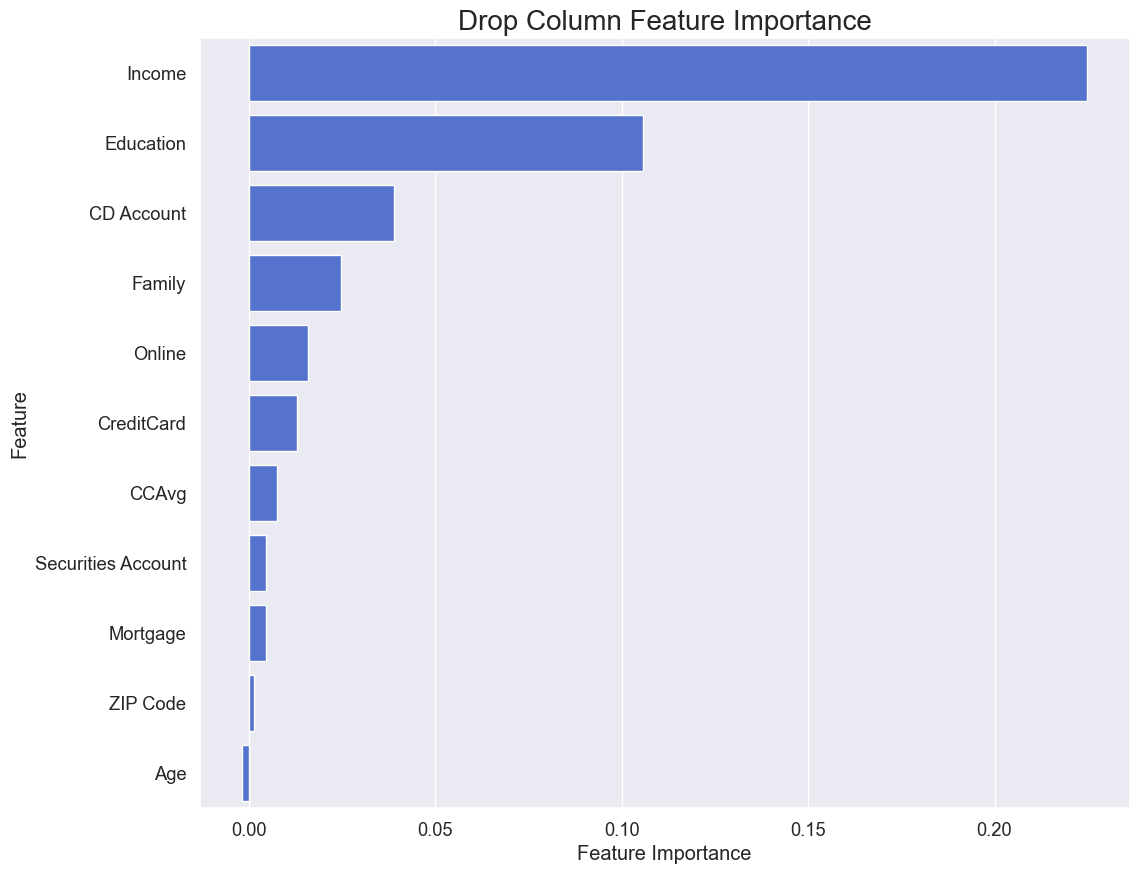

In [58]:
drop_column_importance_plot(logreg_opt, X_train, y_train)

Almost no negative values are observed among Drop-column Feature Importances. In other words, all features are effective in target estimation.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 10.4: Logistic Regression Model Evaluation</p>

Let's evaluate the Logistic Regression model performance using model_evaluation function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3569
           1       0.81      0.65      0.72       346

    accuracy                           0.96      3915
   macro avg       0.89      0.82      0.85      3915
weighted avg       0.95      0.96      0.95      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       892
           1       0.72      0.67      0.69        87

    accuracy                           0.95       979
   macro avg       0.85      0.82      0.83       979
weighted avg       0.95      0.95      0.95       979



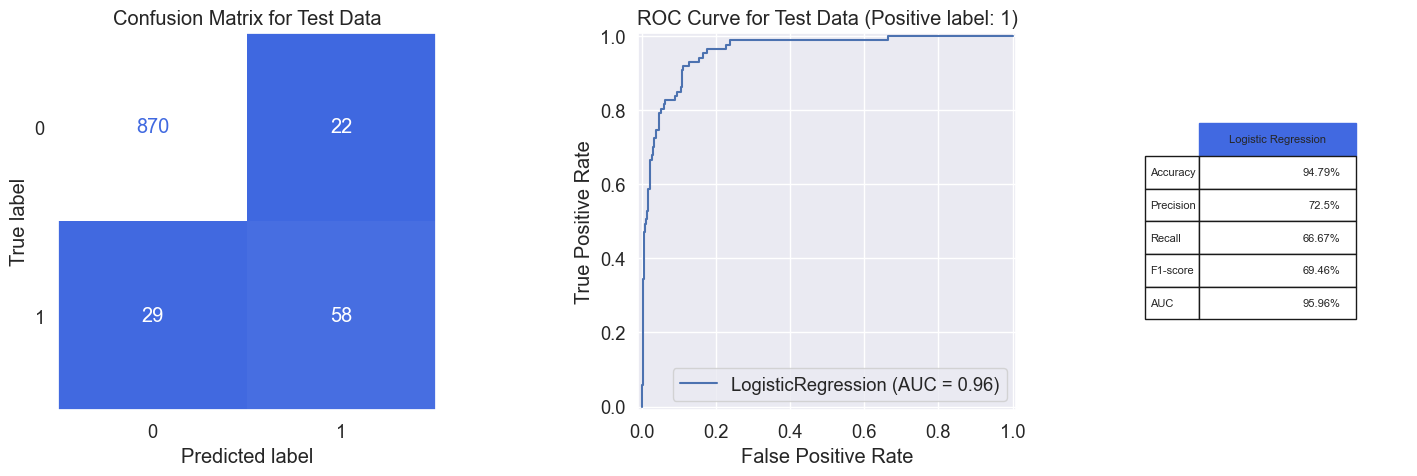

In [59]:
model_evaluation(logreg_opt, X_train, X_test, y_train, y_test, 'Logistic Regression')

A 10% increase in the F1-score of the logistic model compared to the NB Bernoulli model is observed, which is wonderful.

In [60]:
# Save the final performance of Logistic Regression classifier
logreg_result = metrics_calculator(logreg_opt, X_test, y_test, 'Logistic Regression')

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 11: KNN Model Building</p>

__KNN (K-Nearest Neighbors)__ is a supervised learning algorithm used for classification and regression problems in machine learning. The algorithm works by finding the K nearest data points to a given test sample, and then classifying the test sample based on the majority class among the K nearest neighbors. The algorithm uses a distance metric (such as Euclidean distance) to determine the nearest neighbors. The value of K is a hyperparameter and determines the number of neighbors used to make the prediction.

<h4 align="left"><font color='lightblue'>Advantages:</font></h4>

* Easy to implement and understand.
* No need for training, it saves the training data and does not need to estimate parameters.
* Can be used for both classification and regression problems.

<h4 align="left"><font color='lightblue'>Disadvantages:</font></h4>

* It requires a large amount of memory to store the training data.
* Computationally expensive during prediction stage.
* Does not work well with high dimensional data as the distance metric becomes less effective.
* It can be biased towards the majority class.
* Sensitive to outliers.
* Sensitive to irrelevant features and noisy data. It's important to perform proper feature selection.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 11.1: Scale Data using Standard Scaler</p>

As KNN uses a distance metric to find its nearest neighbors, standard scaling (or normalization) is necessary to rescale the features so they have the same scale. Features with different scales and distributions can affect the distance calculation and affect the algorithm's performance.

In [61]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [62]:
# Scale the training and test data using the same scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert training and test sets from numpy array to pandas dataframes
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 11.2: KNN Hyperparameter Tuning</p>

KNN classifier hyperparameters are as follows:

>* __n_neighbors:__ This is the number of nearest neighbors that will be used to predict the class of a new sample. 
>
>* __weights:__ This determines how the distances between samples are weighted when making predictions. 
>    * uniform - all neighbors are weighted equally
>    * distance - neighbors closer to the sample are weighted more heavily
>
>* __metric:__ This is the distance metric used to determine the closest neighbors. The options are: 
>    * euclidean
>    * manhattan
>    * minkowski (the generalization of both distances)
>
>* __p:__ This is the power parameter for the Minkowski metric. When p=1, the Minkowski metric is equivalent to the Manhattan distance; when p=2, it is equivalent to the Euclidean distance. A value of p other than 1 or 2 can be used to weight the contribution of the distances between coordinates differently.

We need to tune the value of hyperparameters for our knn classifier. For this purpose, first we define our hyperparameters grid, and then call tune_clf_hyperparameters function to find the best combination of hyperparameters:

In [63]:
# Define hyperparameters grid to search
param_grid = [{'n_neighbors': np.arange(2, 30), 'metric': ['euclidean','manhattan'], 'weights': ['uniform']},
              {'n_neighbors': np.arange(2, 30), 'metric': ['minkowski'], 'p': [3,4,5], 'weights': ['uniform']}]

Let's call tune_clf_hyperparameters function for hyperparameter tuning:

In [64]:
# Create a KNN classifier object
knn = KNeighborsClassifier()

# Find the best classifier with the optimal hyperparameters
knn_opt = tune_clf_hyperparameters(knn, param_grid, X_train, y_train)

Best hyperparameters:
 {'metric': 'minkowski', 'n_neighbors': 3, 'p': 3, 'weights': 'uniform'}


<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 11.3: KNN Feature Subset Selection</p>

KNN classifiers are sensitive to irrelevant features because they measure distances between instances and weigh each feature equally in the distance calculation. This means that a feature with a high level of randomness or noise can have a large influence on the calculated distances, resulting in inaccurate predictions:

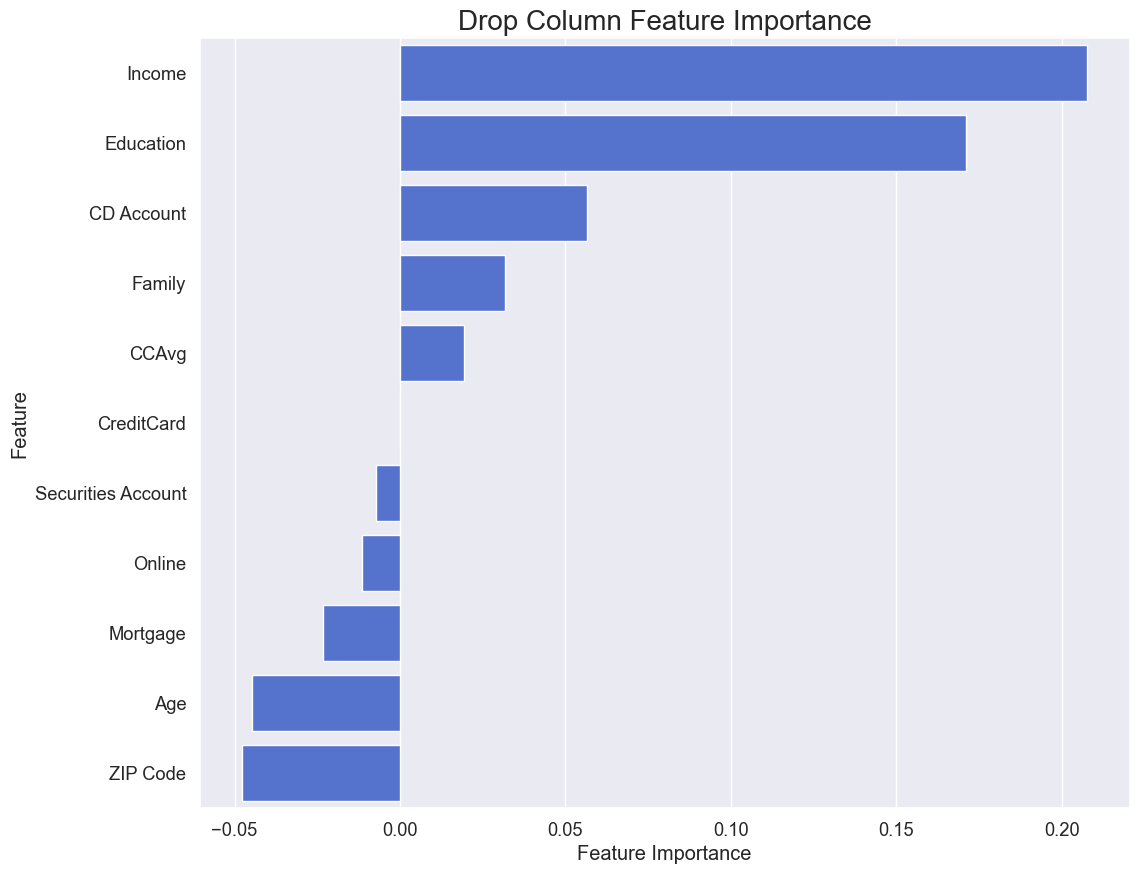

In [65]:
drop_column_importance_plot(knn_opt, X_train, y_train)

In the Drop-Column feature importance output results, several features with negative importance are observed. Removing these features improves the performance of the model. One of these features with the most negative importance value is the ZIP Code, which we already realized in the 3d step, that it is an unimportant feature due to its large number of categories. 
We filter our dataset:

In [66]:
# Find Important features with positive feature_importance value
feature_importances = drop_column_importance(knn_opt, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0]['feature']

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

Let's tune the hyperparameters of our model again after removing the irrelevant features:

In [67]:
# Create a KNN classifier object
knn = KNeighborsClassifier()

# Find the best classifier with the optimal hyperparameters
knn_opt = tune_clf_hyperparameters(knn, param_grid, X_train, y_train)

Best hyperparameters:
 {'metric': 'minkowski', 'n_neighbors': 3, 'p': 5, 'weights': 'uniform'}


<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 11.4: KNN Model Evaluation</p>

Let's evaluate the KNN model performance using model_evaluation function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3569
           1       0.99      0.90      0.94       346

    accuracy                           0.99      3915
   macro avg       0.99      0.95      0.97      3915
weighted avg       0.99      0.99      0.99      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.95      0.87      0.91        87

    accuracy                           0.98       979
   macro avg       0.97      0.93      0.95       979
weighted avg       0.98      0.98      0.98       979



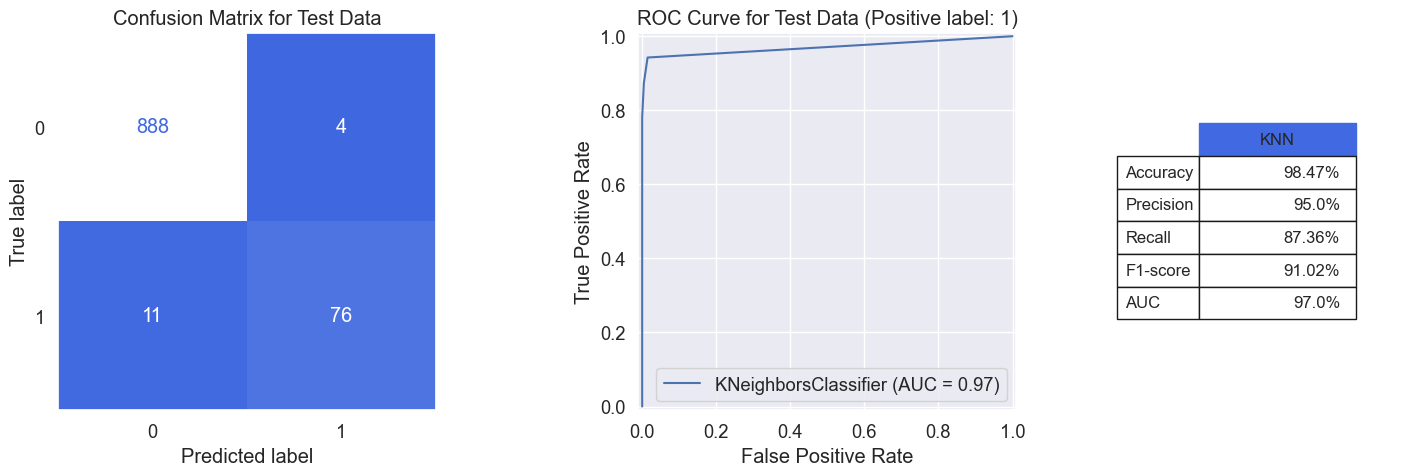

In [68]:
model_evaluation(knn_opt, X_train, X_test, y_train, y_test, 'KNN')

We got an astonishing 91% F1-score, 95% precision and 87% recall using the simple KNN classifier!

In [69]:
# Save the final performance of KNN classifier
knn_result = metrics_calculator(knn_opt, X_test, y_test, 'K-Nearest Neighbors')

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 12: SVM Model Building</p>

__Support Vector Machine (SVM)__ is a type of supervised learning algorithm that is used for classification or regression tasks. It works by finding the best boundary (also known as the decision boundary) that separates the data points into classes, while maximizing the margin (the distance between the boundary and the closest data points from each class, known as support vectors). SVM can handle non-linearly separable data by transforming it into a higher-dimensional space, where it becomes linearly separable.

<h4 align="left"><font color='lightblue'>Advantages:</font></h4>


* __Robust to outliers:__ SVM is less sensitive to outliers compared to other algorithms, making it suitable for tasks where the presence of outliers is expected.

* __Versatile:__ SVM can be used for classification and regression tasks, as well as handling non-linear data through the use of kernel functions.

* __Effective in high dimensional spaces:__ SVM is effective in higher dimensional spaces, where the number of features is greater than the number of samples. 

* __Good performance on smaller datasets:__ SVM has a good performance even on smaller datasets and it doesn't require a large amount of training data to produce accurate results.


<h4 align="left"><font color='lightblue'>Disadvantages:</font></h4>

* __Poor performance on large datasets:__ SVM can be computationally intensive and may become slow when the dataset is large.

* __Overfitting:__ SVM can overfit the data, especially when the number of features is much higher than the number of samples.

* __Limited interpretability:__ SVM is a black-box model and it can be difficult to interpret the results and understand how the algorithm makes predictions.

* __Difficulty in choosing the right kernel function:__ The choice of the kernel function is crucial for the performance of SVM and it can be difficult to determine the best one for a particular problem.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 12.1: Scale Data using Standard Scaler</p>

SVM (Support Vector Machine) is a distance-based classifier. SVM works by finding the boundary that best separates the data into classes, while maximizing the margin (the distance between the boundary and the closest data points from each class, known as support vectors). This means that SVM is based on the concept of distance and seeks to find the optimal boundary that maximizes the distance between the classes. Therefore, Standard Scaling must be performed before model building:

In [70]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [71]:
# Scale the training and test data using the same scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert training and test sets from numpy array to pandas dataframes
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 12.2: SVM Hyperparameter Tuning</p>

SVM classifier hyperparameters are as follows:

> * __C:__ This hyperparameter controls the trade-off between achieving a low training error and a low testing error. A smaller value of C results in a wider margin and a larger number of misclassified training examples, while a larger value of C results in a narrower margin and fewer misclassified training examples.
>
> * __kernel:__ This hyperparameter defines the type of kernel function used to transform the input data into a higher dimensional space where a linear boundary can be found. Common kernel functions include the linear, polynomial, rbf(radial basis function), sigmoid and precomputed kernels.
>
> * __gamma:__ Kernel coefficient for rbf, poly and sigmoid kernels.
>
> * __degree:__ This hyperparameter is only relevant when using the polynomial kernel. It defines the degree of the polynomial function used to transform the input data.

The performance of an SVM classifier can be greatly affected by the choice of hyperparameters, and finding the optimal hyperparameters can help improve the performance of the classifier. Therefore, again we define the hyperparameters grid for search, and then call tune_clf_hyperparameters function to find the optimal values for the SVM hyperparameters that best fit our data:

In [72]:
# Weights associated with classes
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,0.5,12)]

# Define the hyperparameter grid to search
param_grid = [{'kernel': ['poly'], 
               'degree': [2,3,4,5], 
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
               'C': [0.01,0.1,1, 10, 100, 1000],
               'class_weight': class_weights},
                  
              {'kernel': ['rbf','sigmoid'],
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
               'C': [0.01,0.1,1, 10, 100, 1000],
               'class_weight': class_weights},
                  
              {'kernel': ['linear'],
               'C': [0.01,0.1,1, 10, 100, 1000],
               'class_weight': class_weights}
             ]

Tuning hyperparameters for Support Vector Machines (SVM) can be time-consuming as it involves training the model multiple times with different hyperparameter values and evaluating their performance to find the optimal set of hyperparameters. After tuning SVM hyperparameters once, we found that the rbf kernel is the optimal kernel for this dataset. Therefore, we limit our param_grid to the rbf kernel to reduce the program's run time:

In [73]:
# Weights associated with classes
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,0.5,12)]

# Define the hyperparameter grid to search
param_grid = [{'kernel': ['rbf'],
               'gamma': [0.1, 0.01, 0.001, 0.0001], 
               'C': [0.1, 1, 10, 100, 1000],
               'class_weight': class_weights}]  

Let's call tune_clf_hyperparameters function for hyperparameter tuning:

In [74]:
# Create a SVC object
svm = SVC(probability=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
svm_opt = tune_clf_hyperparameters(svm, param_grid, X_train, y_train)

Best hyperparameters:
 {'C': 100, 'class_weight': {0: 0.3639090909090909, 1: 0.636090909090909}, 'gamma': 0.01, 'kernel': 'rbf'}


<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 12.3: SVM Feature Subset Selection</p>

SVM classifiers can be sensitive to irrelevant features. If the input data contains irrelevant features, these features can negatively impact the performance of the SVM classifier. This is because the SVM algorithm considers all features equally when finding the decision boundary, and irrelevant features can distract the algorithm from finding the boundary that separates the classes effectively.

To avoid this issue, it is recommended to perform feature selection before training an SVM classifier, which involves removing any irrelevant or redundant features from the input data. This can improve the performance of the SVM classifier by reducing the complexity of the problem and allowing the algorithm to focus on the most relevant features.

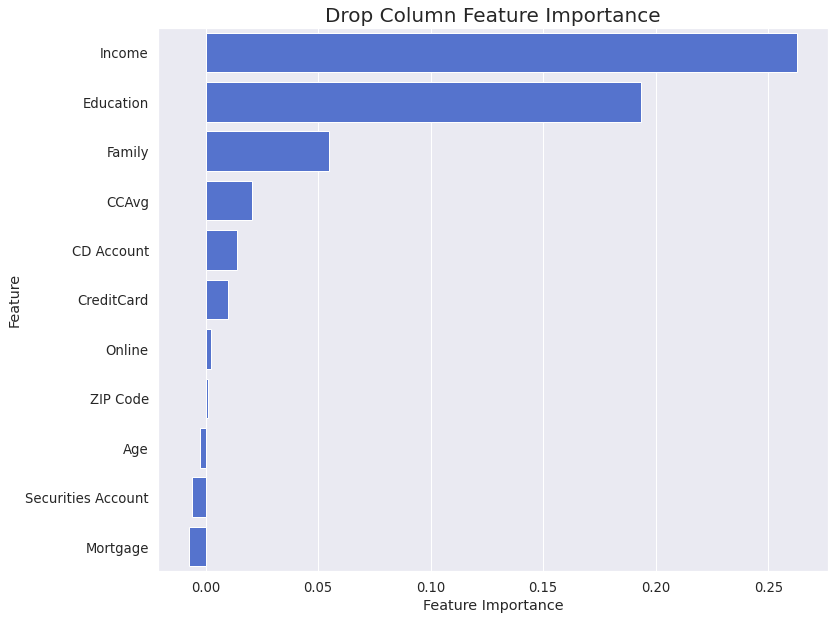

In [72]:
drop_column_importance_plot(svm_opt, X_train, y_train)

In the Drop-Column feature importance output results, several features with negative importance are observed. Removing these features improves the performance of the model. Let's filter our the dataset:

In [73]:
# Find Important features with positive feature_importance value
feature_importances = drop_column_importance(svm_opt, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0.01]['feature']  # Threshold value of 0.01

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

Let's tune the hyperparameters of our model again after removing the irrelevant features:

In [74]:
# Create a SVC object
svm = SVC(probability=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
svm_opt = tune_clf_hyperparameters(svm, param_grid, X_train, y_train)

Best hyperparameters:
 {'C': 1000, 'class_weight': {0: 0.4546363636363636, 1: 0.5453636363636364}, 'gamma': 0.1, 'kernel': 'rbf'}


<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 12.4: SVM Model Evaluation</p>

Let's evaluate the SVM model performance using model_evaluation function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3569
           1       0.97      0.93      0.95       346

    accuracy                           0.99      3915
   macro avg       0.98      0.97      0.97      3915
weighted avg       0.99      0.99      0.99      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       892
           1       0.94      0.89      0.91        87

    accuracy                           0.98       979
   macro avg       0.96      0.94      0.95       979
weighted avg       0.98      0.98      0.98       979



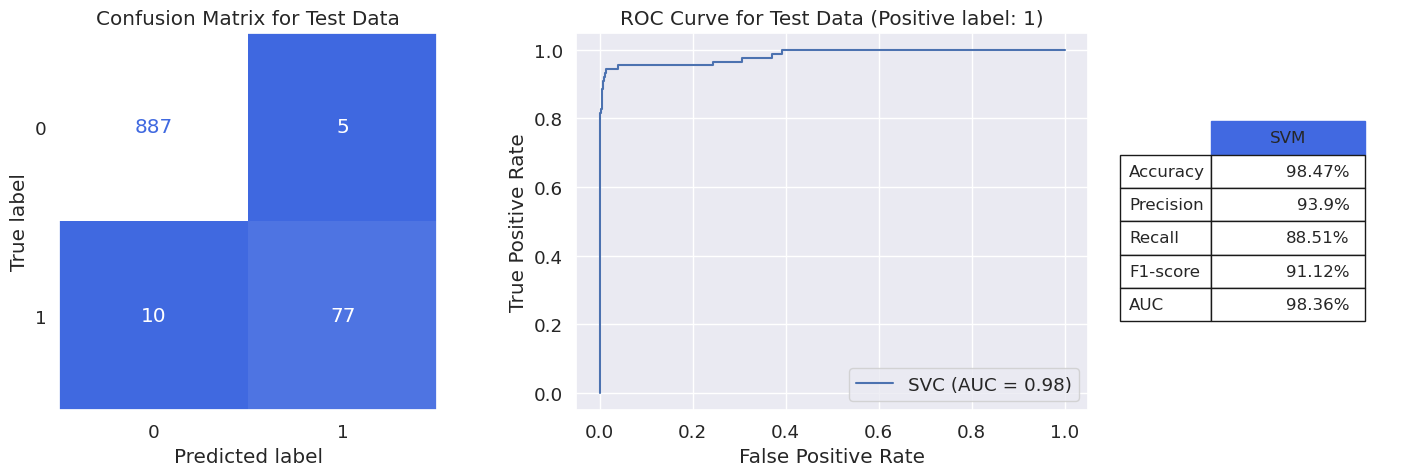

In [75]:
model_evaluation(svm_opt, X_train, X_test, y_train, y_test, 'SVM')

We achieved the same f1-score for our SVM model compared to KNN model, but on the other hand, the value of AUC has been improved to 0.98!

In [76]:
# Save the final performance of SVM classifier
svm_result = metrics_calculator(svm_opt, X_test, y_test, 'SVM')

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 13: Decision Tree Model Building</p>

A Decision Tree is a tree-based supervised learning algorithm that can be used for classification or regression tasks. It works by recursively splitting the data into subsets based on the values of the features, with the goal of minimizing a cost function, such as Gini impurity or entropy.

<h4 align="left"><font color='midnightblue'>Advantages:</font></h4>

* __Easy to understand and interpret:__ Decision Trees are simple to understand and visualize.

* __Handles both numerical and categorical data:__ Decision Trees can handle both numerical and categorical data.

* __Feature selection:__ Decision Trees can be used for feature selection, as important features will appear near the root of the tree.

* __Non-parametric:__ Decision Trees are non-parametric, meaning that they make no assumptions about the underlying distribution of the data.


<h4 align="left"><font color='midnightblue'>Disadvantages:</font></h4>

* __Overfitting:__ Decision Trees can be prone to overfitting, especially with deep trees or with small training sets. This can result in poor generalization to new data.

* __Instability:__ Small changes in the data can result in large changes in the tree, making Decision Trees unstable.

* __Bias towards features with many categories:__ Decision Trees can be biased towards features with many categories, as they may dominate the construction of the tree.

* __Poor approximation of complex functions:__ Decision Trees may not be suitable for approximating complex functions, as they are limited by the axis-parallel splits at each node.

__Note:__ Decision Trees do not require standard scaling of the data before model building. Standard scaling is typically used for algorithms that are sensitive to the scale of the input features, such as distance-based algorithms like KNN and SVM.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 13.1: Decision Tree Hyperparameter Tuning</p>

__Decision Tree__ classifiers are prone to overfitting. This occurs when the tree is too complex and fits the training data too closely, capturing even the noise in the data.


<h4 align="left"><font color='midnightblue'>Ways to prevent overfitting in decision tree classifiers:</font></h4>

* __Pruning:__ Removing branches of the tree that do not contribute much to the classification.
* __Using ensemble methods:__ Combining multiple decision trees to obtain a more robust model.
* __Limiting tree size:__ Setting a minimum number of samples required to split an internal node or a maximum depth for the tree.

<h4 align="left"><font color='midnightblue'>The following are the most common hyperparameters for Decision Tree Classifiers:</font></h4>

>* __Criterion:__ This hyperparameter determines the criterion used to measure the quality of a split. Commonly used criteria are "Gini Impurity" and "Information Gain".
>
>* __Maximum depth:__ This hyperparameter controls the maximum depth of the tree. The deeper the tree, the more complex it becomes, which can lead to overfitting. Setting a maximum depth can prevent overfitting by limiting the size of the tree.
>
>* __Minimum samples per split:__ This hyperparameter sets the minimum number of samples required to split an internal node. If the number of samples at a node is less than this value, the node cannot be split further. This can also prevent overfitting by limiting the size of the tree.
>
>* __Minimum samples per leaf:__ This hyperparameter sets the minimum number of samples required for a leaf node. If a leaf node has fewer samples than this value, it can be removed.
>
>* __Maximum features:__ This hyperparameter determines the maximum number of features to consider when splitting a node. It is used to prevent overfitting by reducing the complexity of the model.
>
>* __Class_weight:__ Weights associated with classes.


Again we define our hyperparameters grid using the above hyperparameteres and then call tune_clf_hyperparameters function to find the best combination:

In [77]:
# Weights associated with classes
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,1,20)]
    
# Define the hyperparameter grid
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': np.arange(1, 10),
              'min_samples_split': np.arange(1, 10),
              'min_samples_leaf': np.arange(1, 10),
              'max_features': [None, 'sqrt', 'log2'],
              'class_weight': class_weights} 

Let's call tune_clf_hyperparameters function for hyperparameter tuning:

In [78]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Create a  Decision Tree Classifier object
dt = DecisionTreeClassifier(random_state=0)

# Find the best classifier with the optimal hyperparameters
dt_opt = tune_clf_hyperparameters(dt, param_grid, X_train, y_train)

Best hyperparameters:
 {'class_weight': {0: 0.6319473684210526, 1: 0.3680526315789474}, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2}


<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 13.2: Decision Tree Feature Subset Selection</p>

Feature subset selection can be important for a Decision Tree classifier. Removing redundant or irrelevant features can help improve the performance of the model by reducing overfitting, increasing interpretability, and improving computational efficiency. However, the specific importance of feature subset selection depends on the particular problem and dataset being used and in some cases, a Decision Tree model can perform well without any feature subset selection:

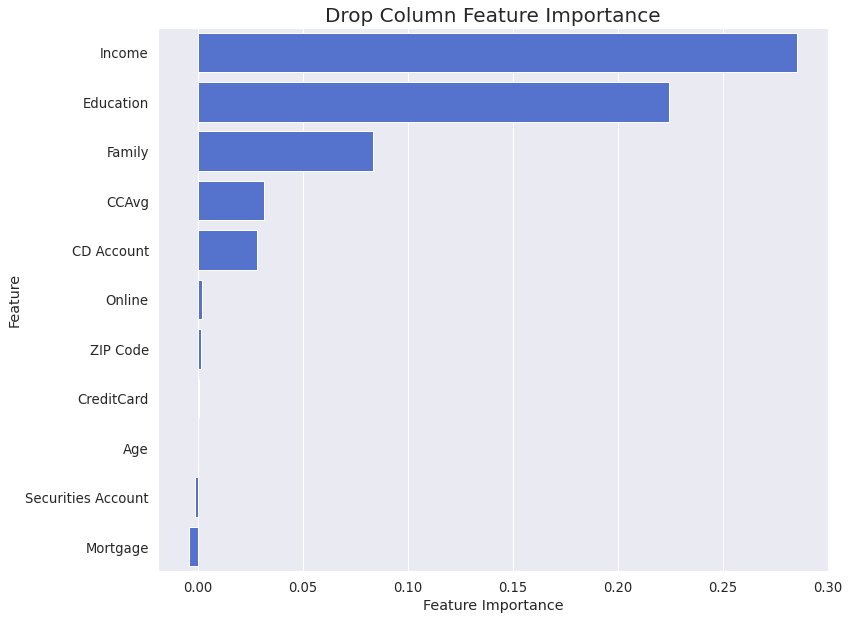

In [79]:
drop_column_importance_plot(dt_opt, X_train, y_train)

In the output of  Drop-Column feature importance method, we observe that some features have negative importance. To enhance the performance of the model, we will remove these features:

In [80]:
# Find Important features with positive feature_importance value
feature_importances = drop_column_importance(dt_opt, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0.01]['feature'] # Threshold value of 0.01

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

Let's tune the hyperparameters of our model again after removing the irrelevant features:

In [81]:
# Create a  Decision Tree Classifier object
dt = DecisionTreeClassifier(random_state=0)

# Find the best classifier with the optimal hyperparameters
dt_opt = tune_clf_hyperparameters(dt, param_grid, X_train, y_train)

Best hyperparameters:
 {'class_weight': {0: 0.5267894736842105, 1: 0.4732105263157895}, 'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 2}


<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 13.3: Decision Tree Model Evaluation</p>

Let's evaluate our final Decision Tree classifier performance using model_evaluation function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3569
           1       0.97      0.90      0.93       346

    accuracy                           0.99      3915
   macro avg       0.98      0.95      0.96      3915
weighted avg       0.99      0.99      0.99      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.96      0.86      0.91        87

    accuracy                           0.98       979
   macro avg       0.97      0.93      0.95       979
weighted avg       0.98      0.98      0.98       979



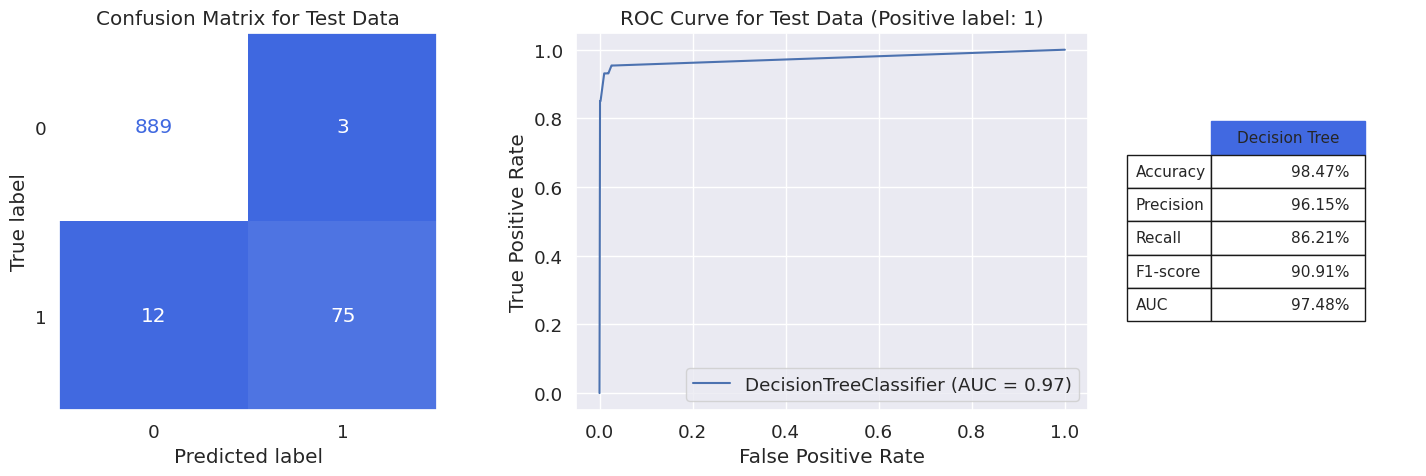

In [82]:
model_evaluation(dt_opt, X_train, X_test, y_train, y_test, 'Decision Tree')

For the decision tree classifier, we got 91% f1-score, similar to the previous two classifiers (KNN & SVM). If we examine the confusion matrix of these models, in all 3 cases, the sum of FN and FP values is equal to 15. In other words, out of 979 bank customers, the models made errors in 15 cases to predict whether the customer accepts the loan or not.

In [83]:
# Save the final performance of Decision Tree classifier
dt_result = metrics_calculator(dt_opt, X_test, y_test, 'Decision Tree')

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 14: Ensemble Learning</p>

__Ensemble learning__ is a machine learning technique that combines the predictions of multiple models to make more accurate and robust predictions. The idea behind ensemble learning is that by combining several models, or weak learners, to solve the same problem, the resulting ensemble model can perform better than any individual model. There are three main ensemble learning methods: 

* __Bagging__ stands for bootstrapped aggregating. In bagging, multiple instances of the same base model are trained in parallel on different bootstrapped samples of the data, and the results are aggregated through an averaging operation. Bagging is best suited for base models with low bias but high variance, as the averaging operation reduces the variance of the final ensemble model.


* __Boosting__ is an iterative technique where multiple instances of the same base model are trained sequentially. At each iteration, the current weak learner is trained based on the previous weak learners and how well they performed on the data. Boosting is best suited for base models with low variance but high bias, as the iterative strategy of learning reduces the bias of the final ensemble model.


* __Stacking__ is a technique where different base models are trained independently, and a meta-model is trained on top of that to predict outputs based on the outputs of the base models. In stacking, the base models are used as features for the meta-model, which makes the final predictions based on the combined information from all the base models.

<h4 align="left"><font color='royalblue'>DTs are often used as base models in ensemble methods because they have several properties that make them well-suited for this purpose:</font></h4>

1. __Simple and easy to understand:__ Decision trees are simple and easy to understand, which makes them a good choice for use as base models in ensemble methods.

2. __Handle non-linear relationships:__ Decision trees can handle non-linear relationships between features and target variables, which makes them a good choice for modeling complex datasets.

3. __Handle missing values and outliers:__ Decision trees are able to handle missing values and outliers in the data, which is important for real-world datasets that often have such problems.

4. __Can capture interactions between features:__ Decision trees can capture interactions between features, which is important for capturing complex relationships in the data.

5. __Fast to train and make predictions:__ Decision trees are fast to train and make predictions, which makes them well-suited for use in large-scale machine learning models.

6. __Provide feature importance:__ Decision trees provide feature importance, which can be useful for understanding which features are contributing the most to the predictions made by the model.

<h3 align="left"><font color='midnightblue'>The most important bagging models based on decision tree classifier are:</font></h3>

* __Random Forest:__ Random forests are an ensemble learning method that utilizes decision trees as its base model. The trees in a random forest are grown on bootstrapped samples of the training data and a randomly selected subset of features. This helps reduce the correlation between the trees and makes the model more robust to missing data. The goal of random forests is to lower the variance of the model by combining multiple deep decision trees. The combination of bagging and random feature subspace selection results in a more robust and accurate model compared to individual decision trees.


* __Extra Trees:__ Extra trees are an extension of random forests that use random splits instead of optimizing the splits based on information gain or other criteria. This makes extra trees faster to train than random forests and less prone to overfitting.

<h3 align="left"><font color='midnightblue'>The most important boosting models are:</font></h3>

* __Adaboost:__ This is one of the earliest and most popular boosting algorithms. It trains a series of weak decision trees and assigns more weight to the misclassified samples in each iteration.


* __Gradient Boosting:__ This is a general purpose boosting algorithm that works well with a variety of weak models, including decision trees. It uses the gradient descent optimization method to minimize the loss function and find the best combination of weak models.


* __XGBoost:__ This is an optimized implementation of gradient boosting and one of the most widely used algorithms in the machine learning community. It is known for its fast training speed, scalability, and ability to handle large datasets.


* __LightGBM:__ This is another optimized implementation of gradient boosting that is designed for large datasets and has been widely adopted in industry.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 15: Random Forest Model Building</p>

__Random Forest__ is an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. The trees in a random forest are grown from randomly selected samples of the training data and a subset of the features. It reduces overfitting and improving its stability by combining multiple trees and hence the name "Forest".

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 15.1: Random Forest Hyperparameter Tuning</p>

Tuning the hyperparameters of a Random Forest classifier can improve its performance on a given problem. The hyperparameters control the complexity and behavior of the model, and their values can have a significant impact on the model's accuracy and generalization ability. For example, setting the maximum depth of the trees too high can result in overfitting, while setting it too low can result in underfitting. The same is true for other hyperparameters such as the minimum number of samples required to split a node, or the number of features considered when splitting a node. Tuning the hyperparameters helps to find the best combination of values that result in the best performance on the particular problem being solved. 

<h3 align="left"><font color='midnightblue'>The hyperparameters of a Random Forest classifier are:</font></h3>

> * __n_estimators:__ The number of trees in the forest.
>
> * __criterion:__ The function to measure the quality of a split. Common criteria include Gini impurity and information gain.
>
> * __max_depth:__ The maximum depth of a tree. This can be used to control the complexity of the model and prevent overfitting.
>
> * __min_samples_split:__ The minimum number of samples required to split an internal node.
>
> * __min_samples_leaf:__ The minimum number of samples required to be at a leaf node.
>
> * __bootstrap:__ Whether or not to sample with replacement when building the trees in the forest.
>
> * __oob_score:__ Whether or not to use out-of-bag samples to estimate the generalization accuracy.
>
> * __class_weight:__ Weights associated with classes.
>
> * __max_features:__ The maximum number of features to consider when splitting a node. This can be set as a number or a float (percentage) or 'sqrt' or 'log2'.

We set the range of values for each hyperparameter that we want to consider for our Random Forest classifier, and then use tune_clf_hyperparameters function to find the best combination of hyperparameters that provides the best results:

__Note:__ Trees that compose a forest can either be __shallow__, meaning they have a limited number of branches or levels, or __deep__, meaning they have many branches or levels and are not fully grown. __Deep trees__ have __low bias__ but __high variance__ and, so, are relevant choices for __bagging methods__ that is mainly focused at __reducing variance__. We consider to have deep trees in choosing the range of values for random forest hyperparameters.

In [84]:
# Weights associated with classes
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,1,20)]

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150], 
    'max_depth': np.arange(5, 12),
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': class_weights
}

Let's call tune_clf_hyperparameters function for hyperparameter tuning:

In [85]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Create a random forest classifier object
rf = RandomForestClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
rf_opt = tune_clf_hyperparameters(rf, param_grid, X_train, y_train)

Best hyperparameters:
 {'class_weight': {0: 0.5793684210526315, 1: 0.42063157894736847}, 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 15.2: Random Forest Feature Subset Selection</p>

Feature selection is important for random forest classifier because it helps to improve the model's performance, reduce overfitting, and speed up training time by removing irrelevant, redundant or noisy features from the data. Let's call drop_column_importance_plot function:

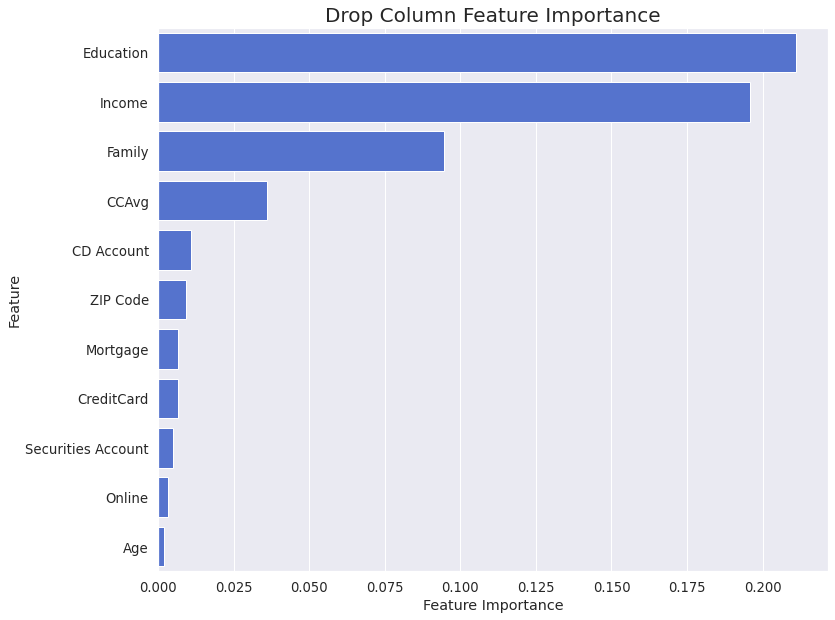

In [86]:
drop_column_importance_plot(rf_opt, X_train, y_train)

No negative values are observed among Drop-column Feature Importances. So, all features are effective in estimating the target and none of them are considered to be detrimental or redundant.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 15.3: Random Forest Model Evaluation</p>

Let's evaluate our optimal Random Forest classifier performance using model_evaluation function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       1.00      0.95      0.97       346

    accuracy                           1.00      3915
   macro avg       1.00      0.98      0.99      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.96      0.89      0.92        87

    accuracy                           0.99       979
   macro avg       0.98      0.94      0.96       979
weighted avg       0.99      0.99      0.99       979



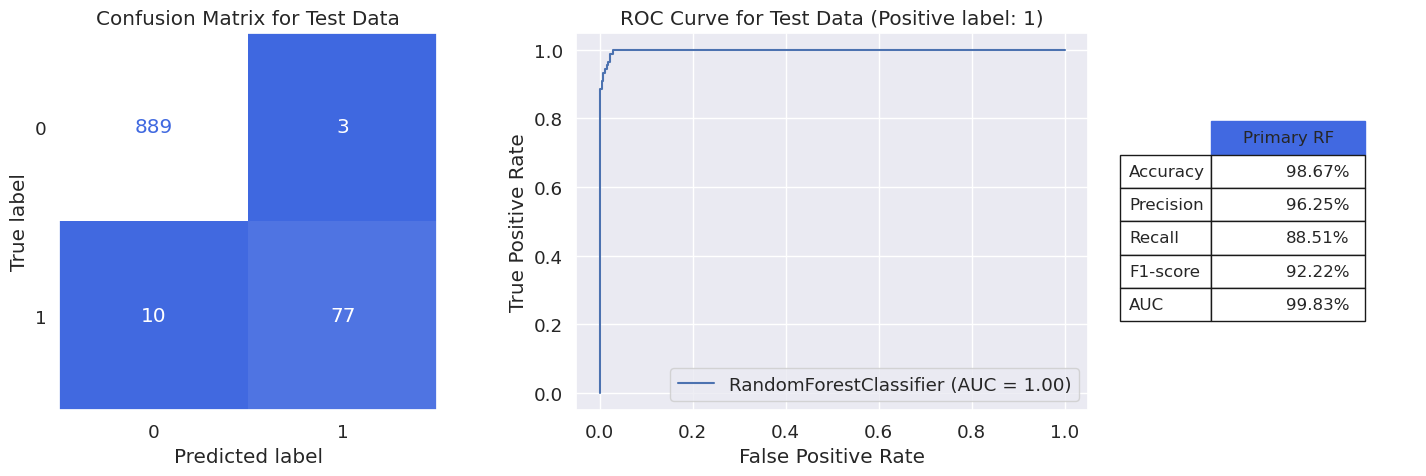

In [87]:
model_evaluation(rf_opt, X_train, X_test, y_train, y_test, 'Primary RF')

If we compare the values of precision, recall and f1-score for class 1 (more important class) on both training and test sets, we see a slight decrease in the scores on the test dataset compared to training, which shows that the model is fairly overfit.
Overfitting of the model is due to its high variance, and in the following, we try to release the model from overfitting by applying a small change in the value of hyperparameters, hoping that the performance of the model will improve on the test data.

<h4 align="left"><font color='royalblue'>How do each of these Random Forest classifier hyperparameters increase model variance?</font></h4>

> * __n_estimators__ - Increasing the number of trees in the forest will increase the variance, as more trees in the forest can capture more diverse patterns in the data.
>
> * __max_depth__ - Increasing the maximum depth of a tree allows the tree to capture more complex patterns in the data, increasing its variance.
>
> * __min_samples_split__ - Decreasing the minimum number of samples required to split an internal node will increase the variance as it allows for more splits to occur.
>
> * __min_samples_leaf__ - Decreasing the minimum number of samples required to be at a leaf node will increase the variance as it allows for smaller leaves to form.
>
> * __max_features__ - Increasing the maximum number of features to consider when splitting a node will increase the variance as it allows for more diverse sets of features to be considered when splitting.
>
> * __bootstrap__ - Sampling with replacement when building the trees in the forest will increase the variance as it allows for more diverse sets of samples to be used for each tree.

Among the optimal values obtained for hyperparameters, we only increase the value of __min_samples_leaf__ from 2 to 6 in order to partially reduce the variance of the model:

In [88]:
# Build random forest classifier object considering the obtained optimal values for hyperparameters
rf_final = RandomForestClassifier(criterion='gini', max_features=None, bootstrap=True,  n_estimators=100, 
                                  max_depth = 9,  min_samples_leaf=6, min_samples_split=2,
                                  class_weight={0: 0.58, 1: 0.42}, random_state=0)
                             
                            
# Train the final Random Forest model
rf_final.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.58, 1: 0.42}, max_depth=9,
                       max_features=None, min_samples_leaf=6, random_state=0)

Let's evaluate our Random Forest classifier again:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3569
           1       0.99      0.90      0.94       346

    accuracy                           0.99      3915
   macro avg       0.99      0.95      0.97      3915
weighted avg       0.99      0.99      0.99      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.99      0.90      0.94        87

    accuracy                           0.99       979
   macro avg       0.99      0.95      0.97       979
weighted avg       0.99      0.99      0.99       979



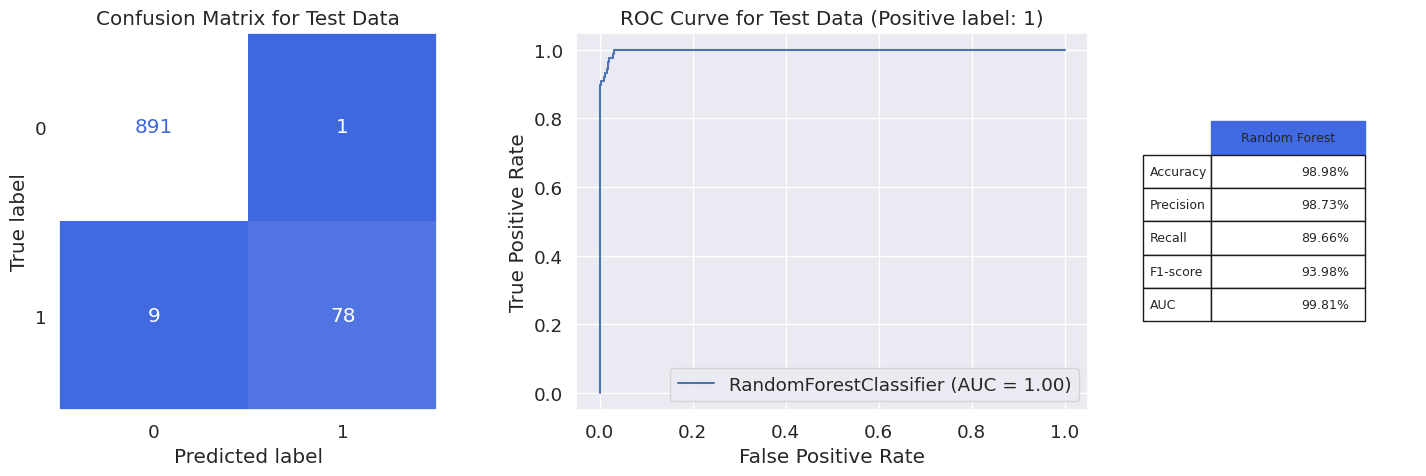

In [89]:
model_evaluation(rf_final, X_train, X_test, y_train, y_test, 'Random Forest')

We got the remarkable 94% f1-score with 99.81% AUC for our Random Forest classifier. Out of 979 bank customers, the model made errors just in 10 cases to predict whether the customer accepts the loan or not.

In [90]:
# Save the final performance of Random Forest classifier
rf_result = metrics_calculator(rf_final, X_test, y_test, 'Random Forest')

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 16: Extra Trees Model Building</p>

__Extra Trees (Extremely Randomized Trees)__ is an ensemble learning method for classification and regression problems. It is a variation of the popular Random Forest algorithm and uses randomization in the construction of decision trees to create a forest of trees. 

In a __Random Forest__, each tree in the ensemble is constructed using a random subset of the features and a random subset of the training samples. The final prediction is made by taking an average (for regression) or a majority vote (for classification) of the predictions made by all the trees in the ensemble. But in an Extra Trees classifier, each tree in the ensemble is constructed using a random subset of the training samples and __a random threshold value is used for each feature to split the samples__. This means that the __Extra Trees__ classifier allows for more randomness in the construction of the trees compared to Random Forest, which can make Extra Trees more suitable for certain types of datasets.

Another difference between the two is that the Extra Trees classifier tends to have slightly higher variance compared to Random Forest, meaning it can be more prone to overfitting the training data. However, this higher variance can also lead to better performance on certain datasets, making Extra Trees a useful alternative to consider in some cases.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 16.1: Extra Trees Hyperparameter Tuning</p>

The hyperparameters of Extra Trees classifier are similar to Random Forest. Therefore, we again set the range of values for each hyperparameter that we want to consider for our Extra Trees classifier, and then use tune_clf_hyperparameters function to find the best combination of hyperparameters that provides the best results:

__Note:__ Tuning Random Forest hyperparameters can be time-consuming. This is because finding the optimal values for the hyperparameters involves training several decision tree classifiers with different combinations of hyperparameter values and evaluating their performance, which can be computationally expensive and time-consuming. Therefore, we performed hyperparameter tuning once and then narrowed the range of hyperparameter values in the following param_grid:

In [91]:
# Weights associated with classes
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,1,20)]

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [70, 100, 150], 
    'max_depth': [10,12,14],
    'min_samples_split': [1,2,3],
    'min_samples_leaf': [1,2,3],
    'class_weight': class_weights
}

Let's call tune_clf_hyperparameters function for hyperparameter tuning:

In [92]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Create a random forest classifier object
et = ExtraTreesClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
et_opt = tune_clf_hyperparameters(et, param_grid, X_train, y_train)

Best hyperparameters:
 {'class_weight': {0: 0.9474210526315789, 1: 0.05257894736842106}, 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}


<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 16.2: Extra Trees Feature Subset Selection</p>

Feature Selection can be important for Extra Trees Classifier as well. Feature selection helps in reducing the dimensionality of the dataset and selecting a subset of relevant features that have the most impact on the model's prediction performance. This can lead to improved model interpretability, reduced overfitting, and faster training times. However, the importance of feature selection for Extra Trees Classifier may vary depending on the specific dataset and problem being solved. It's always a good practice to experiment and evaluate the impact of feature selection on the performance of the model:

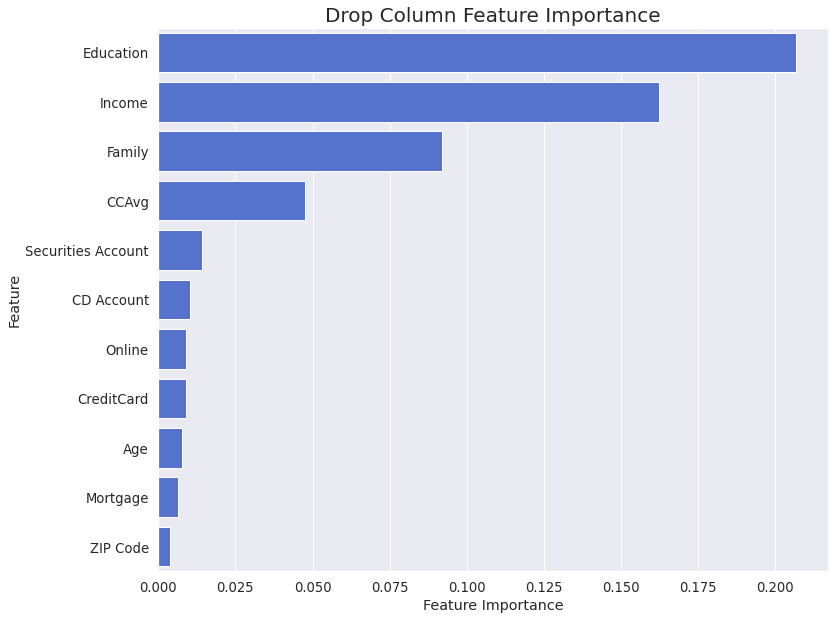

In [93]:
drop_column_importance_plot(et_opt, X_train, y_train)

Again, no negative values are observed among Drop-column Feature Importances. So, all features are effective in estimating the target and none of them are considered to be redundant.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 16.3: Extra Trees Model Evaluation</p>

Let's evaluate our optimal Extra Trees classifier performance using model_evaluation function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3915
   macro avg       1.00      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.98      0.92      0.95        87

    accuracy                           0.99       979
   macro avg       0.98      0.96      0.97       979
weighted avg       0.99      0.99      0.99       979



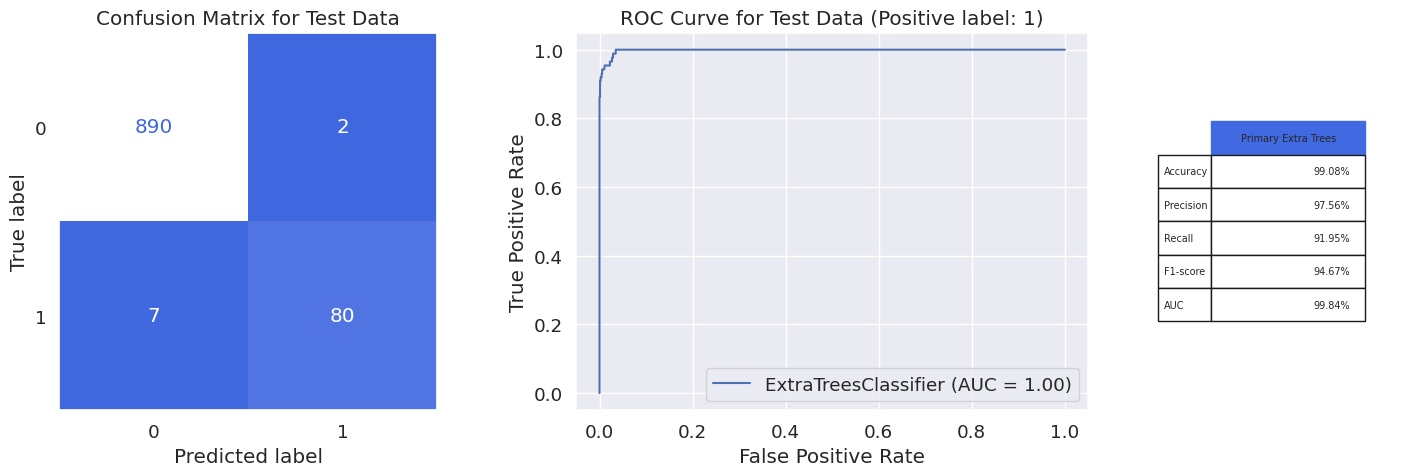

In [94]:
model_evaluation(et_opt, X_train, X_test, y_train, y_test, 'Primary Extra Trees')

The comparison of precision, recall, and f1-score for class 1 between the training and test datasets suggests that the model is slightly overfit. If the values for class 1 show a significant decrease in performance on the test set compared to the training set, it indicates that the model has learned the training data too well and has not generalized well to new unseen data. This overfitting leads to a poor performance on the test set and suggests that the model is not suitable for making accurate predictions on new data.

Based on the explanation given in section 15.3, by increasing the value of min_samples_leaf from 2 to 3, the model becomes less complex and the variance of the model is reduced:

In [95]:
# Build Extra Trees classifier object considering the obtained optimal values for hyperparameters
et_final = ExtraTreesClassifier(criterion='gini', max_features=None, bootstrap=True,  n_estimators=70, 
                                max_depth = 14,  min_samples_leaf=1, min_samples_split=3,
                                class_weight= {0: 0.95, 1: 0.05}, random_state=0)
                             
                            
# Train the final Extra Trees model
et_final.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, class_weight={0: 0.95, 1: 0.05},
                     max_depth=14, max_features=None, min_samples_split=3,
                     n_estimators=70, random_state=0)

Let's evaluate our Extra Trees classifier again:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       1.00      0.96      0.98       346

    accuracy                           1.00      3915
   macro avg       1.00      0.98      0.99      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       892
           1       0.99      0.92      0.95        87

    accuracy                           0.99       979
   macro avg       0.99      0.96      0.97       979
weighted avg       0.99      0.99      0.99       979



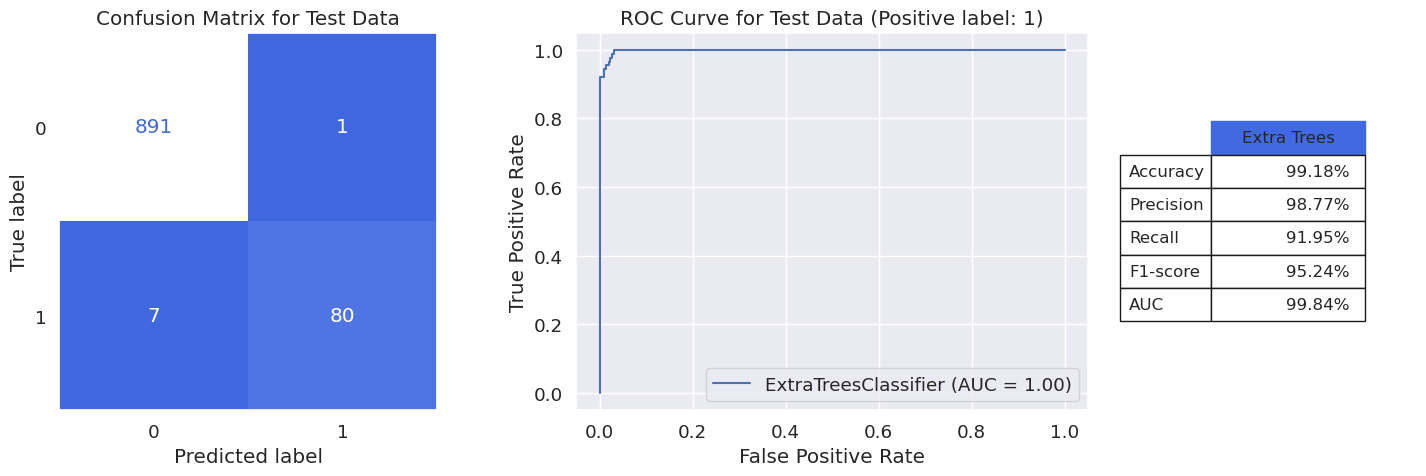

In [96]:
model_evaluation(et_final, X_train, X_test, y_train, y_test, 'Extra Trees')

As can be seen, the model is no longer overfit and the performance of the model on the test data has improved compared to the previous model. We got the astonishing 95% f1-score with 99.84% AUC for our Extra Trees classifier which is our best classifier till now. Out of 979 bank customers, the model made errors just in 8 cases to predict whether the customer accepts the loan or not.

In [97]:
# Save the final performance of Extra Trees classifier
et_result = metrics_calculator(et_final, X_test, y_test, 'Extra Trees')

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 17: AdaBoost Model Building</p>

__AdaBoost (Adaptive Boosting)__ is a popular boosting ensemble learning algorithm that is used for classification and regression tasks. It combines multiple "weak" classifiers to create a strong classifier that makes accurate predictions. The weak classifiers are trained one by one and the algorithm adjusts the weights of the training instances based on their misclassification rates. The idea behind AdaBoost is to focus on the samples that are misclassified by the previous weak classifiers, so that the subsequent weak classifiers can do a better job in classifying those samples. In this way, the algorithm tries to improve the overall accuracy of the classifier by combining the outputs of multiple weak classifiers.

The term "weak classifier" refers to a simple classifier that is not highly accurate, but when combined with other weak classifiers, results in a strong overall classifier. Typically, decision trees are used as the weak classifiers in AdaBoost. However, any machine learning algorithm that accepts weights on the training data can be used as the base learner in AdaBoost.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 17.1: AdaBoost Hyperparameter Tuning</p>

Hyperparameter tuning is generally necessary for most machine learning algorithms, including the AdaBoost classifier. It can help to optimize the performance of the model and avoid overfitting or underfitting.

<h3 align="left"><font color='midnightblue'>The hyperparameters of the AdaBoost classifier include:</font></h3>

> * __learning rate:__ This parameter determines the contribution of each weak learner in the final prediction. A lower learning rate results in a slower convergence, but a more accurate prediction.
>
> * __number of estimators:__ This is the maximum number of weak learners that will be used to create the final strong classifier. A larger number of estimators can lead to a more accurate prediction, but it also increases the computation time.
>
> * __estimator:__ The algorithm used for the weak learner can be selected based on the problem at hand. We choose Decision Tree.

__Note:__ In addition to the hyperparameters of the AdaBoost classifier, such as the learning rate, number of estimators, and sampling strategy, the hyperparameters of the base estimator also need to be optimized to achieve the best performance. Shallow trees have high bias but low variance and, so, are relevant choices for boosting methods that are mainly focused at reducing bias. Shallow trees allow the boosting algorithm to focus on samples that are difficult to classify.

We set the range of values for each hyperparameter that we want to consider for our AdaBoost classifier, and then use tune_clf_hyperparameters function to find the best combination of hyperparameters that provides the best results:

In [98]:
# Define the hyperparameter grid for AdaBoost
ada_param_grid = {
    'base_estimator__max_depth': [3, 5, 7],
    'base_estimator__min_samples_split': [3, 5, 7],
    'base_estimator__min_samples_leaf': [1, 2, 3],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.8, 0.9, 1]
}

Let's call tune_clf_hyperparameters function for hyperparameter tuning:

In [99]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Create the Decision Tree classifier as the base estimator
dt = DecisionTreeClassifier(criterion='gini', max_features=None, random_state=0)

# Create the AdaBoost classifier using Decision Tree as base estimator
ada = AdaBoostClassifier(base_estimator=dt, random_state=0)

# Find the best AdaBoost classifier with the optimal hyperparameters
ada_opt = tune_clf_hyperparameters(ada, ada_param_grid, X_train, y_train)

Best hyperparameters:
 {'base_estimator__max_depth': 5, 'base_estimator__min_samples_leaf': 2, 'base_estimator__min_samples_split': 5, 'learning_rate': 0.9, 'n_estimators': 100}


<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 17.2: AdaBoost Feature Subset Selection</p>

Feature selection can be important for an AdaBoost classifier. Feature selection helps reduce the dimensionality of the data, decrease the computational cost, and prevent overfitting. Additionally, it can improve the interpretability of the model and increase the accuracy of the classifier by focusing on the most relevant features. However, the specific impact of feature selection on an AdaBoost classifier can vary depending on the problem and the data:

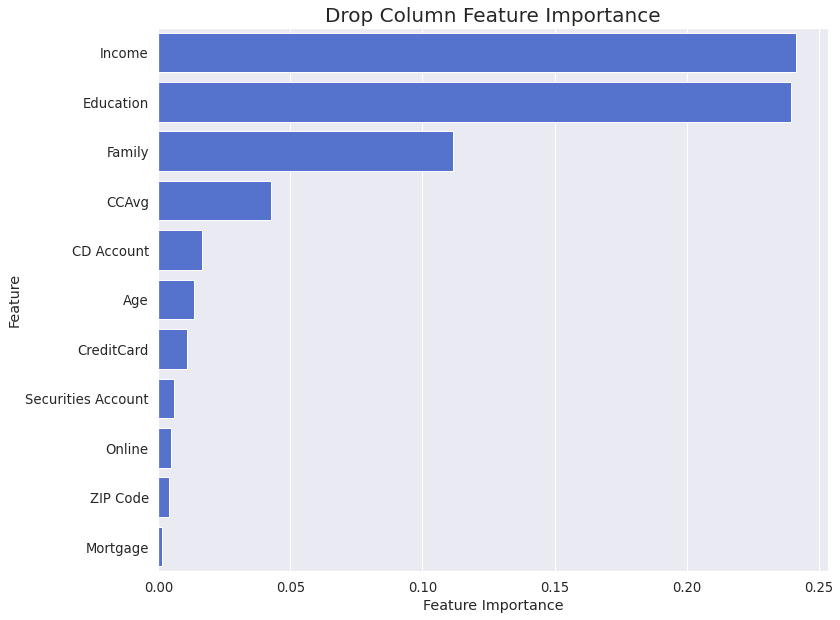

In [100]:
drop_column_importance_plot(ada_opt, X_train, y_train)

The result of the feature importance analysis shows that none of the features have negative values for their drop-column importances. This indicates that all of the features are contributing positively to the estimation of the target and none of them can be considered unnecessary or redundant. All of the features are deemed to be effective in predicting the target.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 17.3: AdaBoost Model Evaluation</p>

Let's evaluate our optimal AdaBoost classifier performance using model_evaluation function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3915
   macro avg       1.00      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       892
           1       0.94      0.91      0.92        87

    accuracy                           0.99       979
   macro avg       0.97      0.95      0.96       979
weighted avg       0.99      0.99      0.99       979



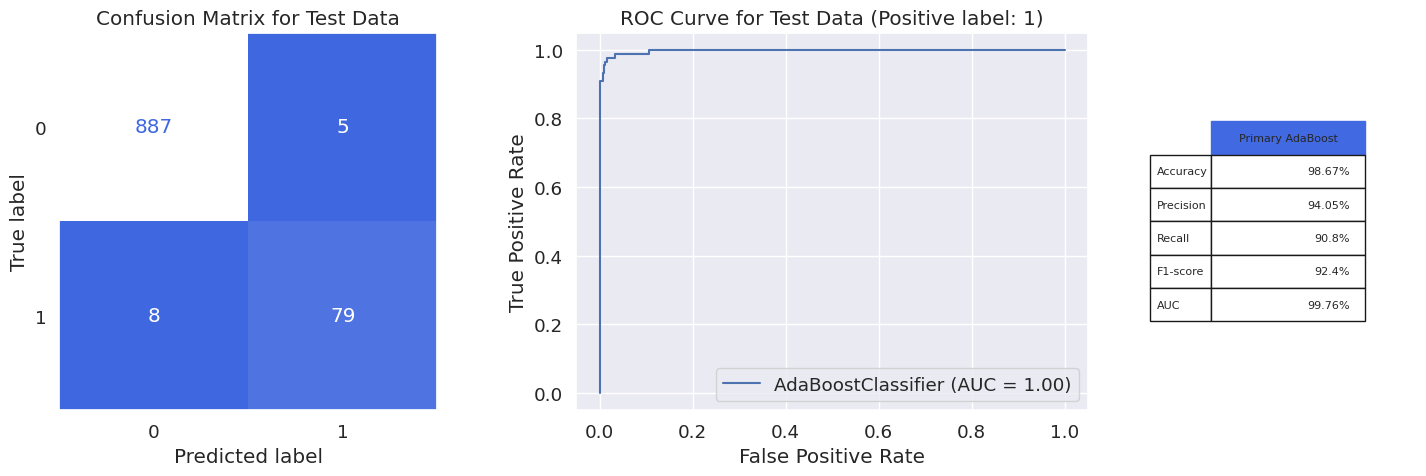

In [101]:
model_evaluation(ada_opt, X_train, X_test, y_train, y_test, 'Primary AdaBoost')

Performance metrics for the minority class on the test data show that the model is not overfitting completely, but may not be the best model for the problem. Overfitting of the classifier is due to its high variance, and to avoid overfitting, we can try regularization techniques, which means applying a small change in the value of hyperparameters to reduce the variance of the classifier.

<h4 align="left"><font color='royalblue'>How to reduce our AdaBoost classifier variance by tuning model hyperparameters?</font></h4>

> * __Decrease the number of trees in the model:__ AdaBoost uses multiple weak learners (in this case decision trees) to build a strong model. Decreasing the number of trees in the model can reduce model variance.
>
> * __Decrease the maximum depth of the decision trees:__ Decreasing the maximum depth of the decision trees can reduce model variance.
>
> * __Increase the minimum number of samples required to split an internal node:__ Increasing the minimum number of samples required to split an internal node can reduce model variance.
>
> * __Increase the minimum number of samples required to be at a leaf node:__ Increasing the minimum number of samples required to be at a leaf node can reduce model variance.
>
> * __Decrease the learning rate:__ The learning rate in AdaBoost determines the weight that each weak learner is given. Decreasing the learning rate can make the model less prone to overfitting.


Among the optimal values obtained for hyperparameters, we only decrease the value of learning_rate from 0.9 to 0.8 in order to partially reduce the variance of the model:

In [102]:
# Create the Decision Tree classifier as the base estimator
dt = DecisionTreeClassifier(criterion='gini', max_features=None, random_state=0, max_depth=5, min_samples_leaf=2, min_samples_split=5)

# Create the AdaBoost classifier using Decision Tree as base estimator
ada_final = AdaBoostClassifier(base_estimator=dt, random_state=0, learning_rate=0.8, n_estimators=100)

# Train the final AdaBoost classifier
ada_final.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                         min_samples_leaf=2,
                                                         min_samples_split=5,
                                                         random_state=0),
                   learning_rate=0.8, n_estimators=100, random_state=0)

Let's evaluate our final AdaBoost classifier:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3915
   macro avg       1.00      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.96      0.92      0.94        87

    accuracy                           0.99       979
   macro avg       0.98      0.96      0.97       979
weighted avg       0.99      0.99      0.99       979



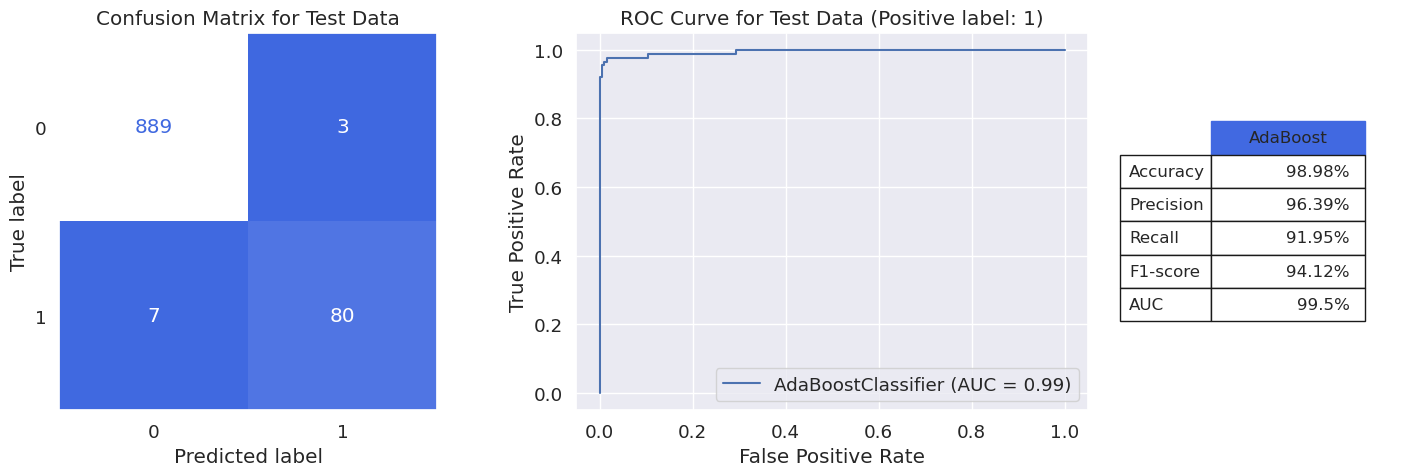

In [103]:
model_evaluation(ada_final, X_train, X_test, y_train, y_test, 'AdaBoost')

The variance of the model is reduced and thus the performance of the model on the test data is improved. Since the difference in scores on the test and training data is not large and the AUC score is high, we can ignore it. The f1-score obtained on the test data is almost the same as the previous bagging models.

__Note:__ The __AUC (Area Under Curve)__ metric measures the performance of a binary classifier by plotting the true positive rate against the false positive rate and calculating the area under the curve. A model that is not overfit will have a high AUC, close to 1, indicating that it has a good balance between true positive and false positive predictions. A model that is overfitting, on the other hand, may have a high accuracy on the training set but a lower AUC on the validation set, as it may be making many false positive predictions. Hence, a high AUC score suggests that the model is not overfitting and has good generalization performance on new, unseen data.

In [104]:
# Save the final performance of AdaBoost classifier
ada_result = metrics_calculator(ada_final, X_test, y_test, 'AdaBoost')

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 18: Gradient Boosting Model Building</p>

__Gradient Boosting__ is an ensemble machine learning technique for classification and regression problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise manner, where each subsequent model tries to correct the mistakes of the previous model. The algorithm iteratively trains decision trees in such a way that the trees are able to fit the negative gradient of the loss function being optimized. The final prediction is made by combining the outputs of all the individual trees. 

__Note :__ The implementation of Gradient Boosting Classifier in scikit-learn's ensemble module (sklearn.ensemble.GradientBoostingClassifier) is based on decision tree as the base estimator. 

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 18.1: Gradient Boosting Hyperparameter Tuning</p>

Tuning the hyperparameters of Gradient Boosting is important. The hyperparameters can significantly impact the model performance, and finding the optimal set of hyperparameters is crucial for achieving good results. An inappropriate setting of hyperparameters can lead to underfitting or overfitting, and affect the model's ability to generalize to unseen data.

<h3 align="left"><font color='midnightblue'>The hyperparameters of Gradient Boosting Classifier include:</font></h3>

> * __n_estimators:__ The number of trees in the ensemble.
>
> * __learning_rate:__ The learning rate shrinks the contribution of each tree by a factor of learning_rate. It is a parameter to control the magnitude of update, and the value should be set lower for a large number of trees.
>
> * __max_depth:__ The maximum depth of the individual decision trees. The deeper the tree, the more splits it has and the more complex the model becomes.
>
> * __min_samples_split:__ The minimum number of samples required to split an internal node.
>
> * __min_samples_leaf:__ The minimum number of samples required to be at a leaf node.
>
> * __max_features:__ The number of features to consider when looking for the best split.
>
> * __subsample:__ The fraction of samples to be used for fitting the individual base learners.
>
> * __loss:__ The loss function to be optimized. The default loss function is ‘deviance’ which refers to logistic regression for binary classification and multinomial deviance for multi-class classification problems.
>
> * __criterion:__ The function to measure the quality of a split. Supported criteria are “friedman_mse” for mean squared error, which is used for regression problems, and “entropy” or “gini” for the information gain, which is used for classification problems.

We again set the range of values for each hyperparameter that we want to consider for our Gradient Boosting classifier, and then use tune_clf_hyperparameters function to find the best combination of hyperparameters that provides the best results:

In [105]:
# Define the hyperparameter grid for tuning
gbc_param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'loss': ['deviance', 'exponential'],
    'criterion': ['friedman_mse', 'squared_error'],
    'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]
}

Since hyperparameter tuning on the above grid can be very time-consuming due to the large size of the grid, after executing it at once and knowing the optimal values , we make the set of grid values smaller:

In [106]:
# Define the hyperparameter grid for tuning
gbc_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 5, 6],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'subsample': [0.9, 1.0],
    'learning_rate': [0.3, 0.4, 0.5]
}

Let's call tune_clf_hyperparameters function for hyperparameter tuning:

In [107]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Initialize the Gradient Boosting Classifier
gbc = GradientBoostingClassifier(max_features=None, loss='deviance', criterion='friedman_mse', random_state=0)

# Find the best hyperparameters from the tuning process
gbc_opt = tune_clf_hyperparameters(gbc, gbc_param_grid, X_train, y_train)

Best hyperparameters:
 {'learning_rate': 0.4, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}


<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 18.2:  Gradient Boosting Feature Subset Selection</p>

The specific impact of feature selection on a gradient boosting classifier can vary depending on the problem and the data. In some cases, gradient boosting algorithms can handle a large number of features without significant degradation in performance, but in other cases, feature selection can still be beneficial.

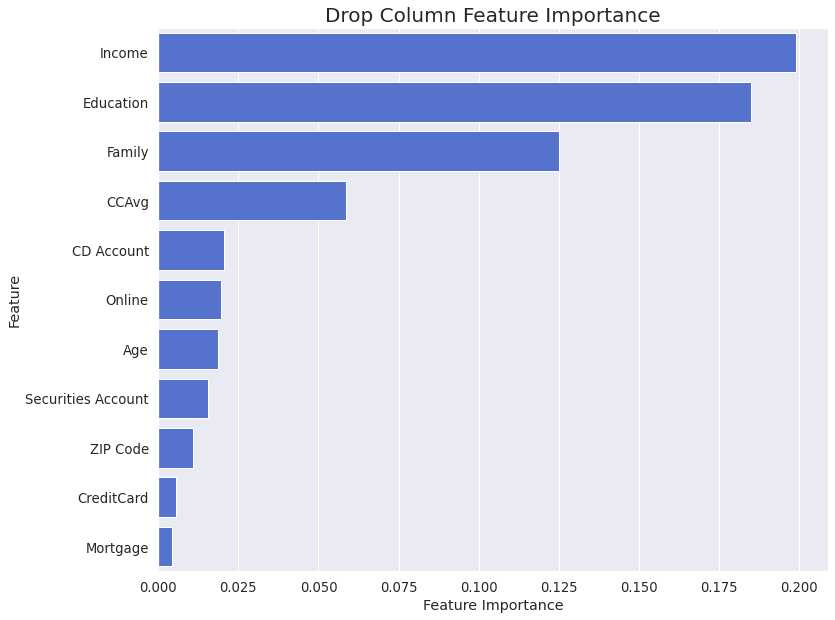

In [108]:
drop_column_importance_plot(gbc_opt, X_train, y_train)

The feature importance analysis reveals that every feature has a positive impact on predicting the target, meaning none of them have a negative impact.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 18.3: Gradient Boosting Model Evaluation</p>

Let's evaluate our optimal Gradient Boosting classifier performance using model_evaluation function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3915
   macro avg       1.00      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       892
           1       0.94      0.92      0.93        87

    accuracy                           0.99       979
   macro avg       0.97      0.96      0.96       979
weighted avg       0.99      0.99      0.99       979



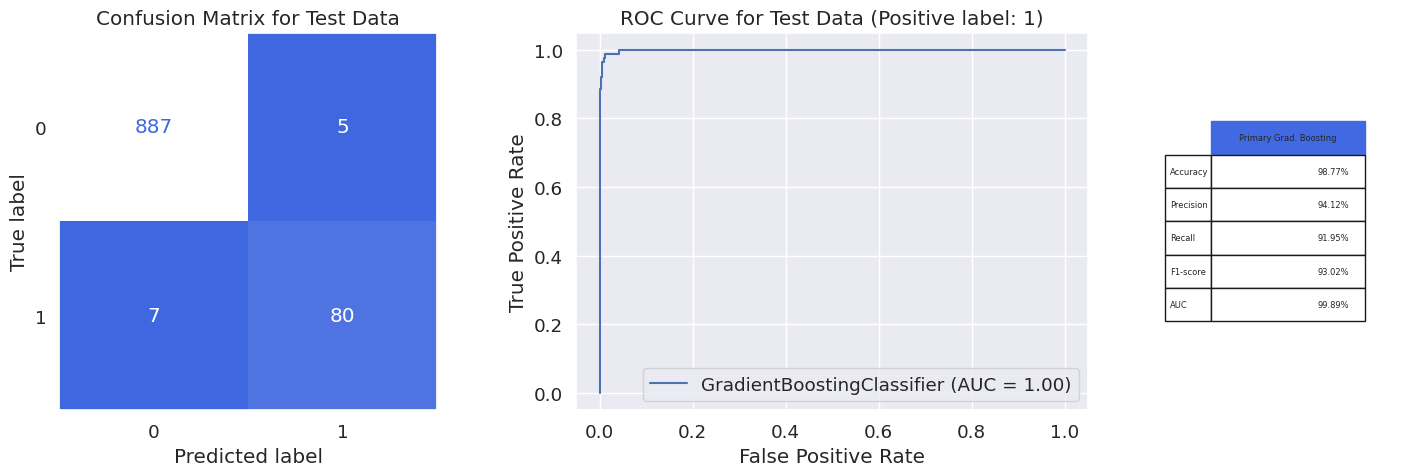

In [109]:
model_evaluation(gbc_opt, X_train, X_test, y_train, y_test, 'Primary Grad. Boosting')

Our Gradient Boosting classifier is fairly overfit on the minority class. Therefore, agian we need to reduce the variance of the classifier by slightly changing the value of hyperparameters.

<h4 align="left"><font color='royalblue'>How to reduce our Gradient Bossting classifier variance by tuning model hyperparameters?</font></h4>

> * __Number of Trees:__ We can reduce the number of trees to reduce model variance. More trees means more complex models, which are more prone to overfitting.
>
> * __Maximum Depth of Trees:__ We can reduce the maximum depth of trees in the model, which will reduce model variance by limiting the number of splits.
>
> * __Learning Rate:__ Decreasing the learning rate will reduce the magnitude of the updates to the model parameters, making it harder for the model to overfit the training data.
>
> * __Subsampling:__ can subsample the training data by taking a smaller sample of it during each iteration of the model training. This will prevent overfitting by introducing randomness into the model.
>
> * __Tree-Specific Hyperparameters:__ We can reduce the variance of the model by adjusting hyperparameters specific to decision trees. For exmale we can increase the minimum number of samples required to split a node or the minimum number of samples in a leaf.

Among the optimal values obtained for hyperparameters, we only decrease the value of learning_rate from 0.4 to 0.2 in order to partially reduce the variance of the model:

In [110]:
# Initialize the Gradient Boosting Classifier
gbc_final = GradientBoostingClassifier(max_features=None, loss='deviance', criterion='friedman_mse',
                                 learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0,
                                 min_samples_leaf=4, min_samples_split=2, random_state=0)

# Train the final AdaBoost classifier
gbc_final.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, min_samples_leaf=4,
                           random_state=0)

Let's evaluate our final Gradient Boosting classifier:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3915
   macro avg       1.00      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       892
           1       0.99      0.92      0.95        87

    accuracy                           0.99       979
   macro avg       0.99      0.96      0.97       979
weighted avg       0.99      0.99      0.99       979



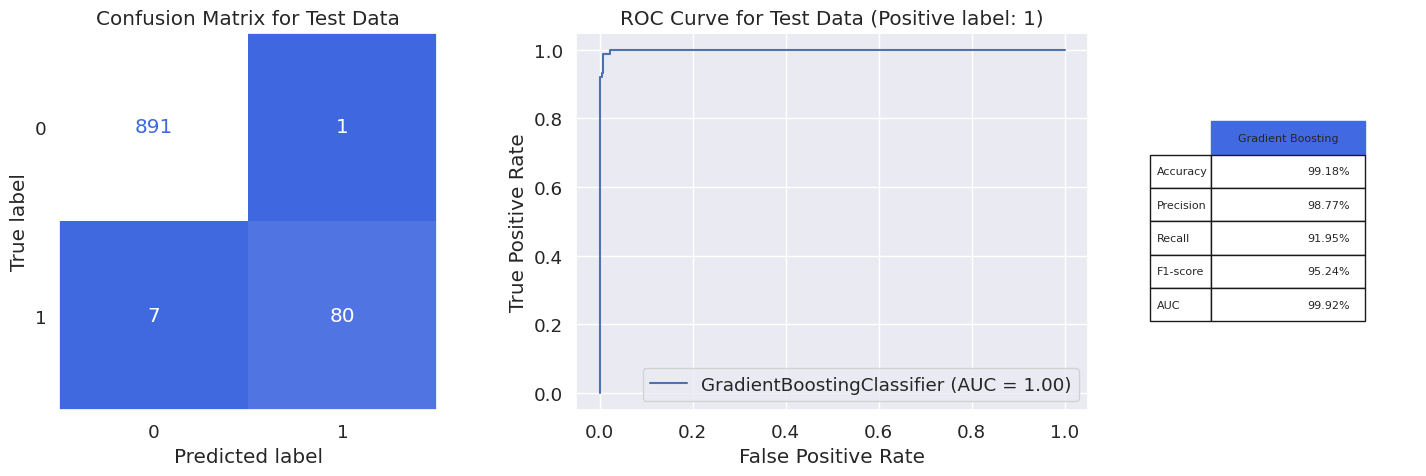

In [111]:
model_evaluation(gbc_final, X_train, X_test, y_train, y_test, 'Gradient Boosting')

The variance of the model is reduced and thus we got the brilliant 95.24% f1-score with 99.92% AUC for our Gradient Boosting classifier which is the best performance among all the classifiers reviewed till now. Out of 979 bank customers, the model made errors just in 8 cases to predict whether the customer accepts the loan or not. Let us unveil our ultimate weapon now: __XGBoost Classifier !__

In [112]:
# Save the final performance of Gradient Boosting classifier
gbc_result = metrics_calculator(gbc_final, X_test, y_test, 'Gradient Boosting')

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 19: XGBoost Model Building</p>

__XGBoost__ is a type of gradient boosting algorithm for tree-based machine learning models. It stands for __eXtreme Gradient Boosting__. XGBoost is a highly optimized implementation of gradient boosting and is designed to be fast and memory efficient.

<h4 align="left"><font color='midnightblue'>XGBoost has several unique features compared to other gradient boosting implementations, such as:</font></h4>

* Handling missing values
* Parallel processing for training and prediction
* Tree pruning for reducing overfitting
* Regularization for preventing overfitting

These features make XGBoost a popular and powerful tool for solving many machine learning problems

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 19.1: XGBoost Hyperparameter Tuning</p>

__XGBoost (eXtreme Gradient Boosting)__ is an open-source library for gradient boosting that is widely used for classification and regression problems. It stands for Extreme Gradient Boosting and is an implementation of gradient boosting trees that is optimized for speed and performance. XGBoost is a highly flexible algorithm that allows users to define custom objectives and evaluation criteria and handles missing values efficiently. 

<h3 align="left"><font color='midnightblue'>XGBoost Advantages:</font></h3>

* __Regularization:__ Unlike the standard GBM implementation, XGBoost has regularization which helps to reduce overfitting.

* __Fast Parallel Processing:__ XGBoost implements parallel processing, making it much faster than GBM. It also supports Hadoop implementation.

* __High Flexibility:__ XGBoost allows users to define custom optimization objectives and evaluation criteria, providing a new level of customization.

* __Handling Missing Values:__ XGBoost has an in-built routine for handling missing values and can learn how to handle them in future predictions.

* __Effective Tree Pruning:__ XGBoost makes splits up to the specified maximum depth and then prunes the tree, whereas GBM stops splitting when it encounters a negative loss.

* __Built-in Cross-Validation and Continued Training:__ XGBoost allows for cross-validation during each boosting iteration, making it easier to determine the optimum number of iterations. Additionally, it can start training from its last iteration of a previous run.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 19.1: XGBoost Hyperparameter Tuning</p>

Building a model with XGBoost is easy, but improving the model requires hyperparameter tuning. This involves adjusting specific settings to optimize the model's performance. Determining the right set of hyperparameters and their ideal values is challenging and requires careful experimentation and analysis. Despite the difficulties in fine-tuning the hyperparameters, XGBoost remains a highly effective solution for predictive modeling.

<h3 align="left"><font color='midnightblue'>The most common hyperparameters used in XGBoost:</font></h3>

>* __eta (Learning rate):__ Step size shrinkage used in updates to prevent overfitting.
>
>* __max_depth:__ Maximum tree depth for base learners. Increasing this value will make the model more complex and more likely to overfit.
>
>* __gamma:__ Minimum loss reduction required to make a further partition on a leaf node of the tree.
>
>* __lambda (reg_lambda):__ L2 regularization term on weights. Increasing this value will make the model more conservative.
>
>* __alpha (reg_alpha):__ L1 regularization term on weights. Increasing this value will force more feature selection.
>
>* __subsample:__ Subsample ratio of the training instances. Setting it to a value less than 1 will make the model more random.
>
>* __colsample_bytree:__ Subsample ratio of columns when constructing each tree.
>
>* __colsample_bylevel:__ Subsample ratio of columns for each level.
>
>* __n_estimators:__ Number of trees in the forest.
>
>* __max_leaf_nodes:__ Maximum number of terminal nodes or leaves in a tree.
>
>* __max_delta_step:__ Maximum delta step for each leaf. It's used for further control over the range of values of weight for each instance.
>
>* __scale_pos_weight:__  It is the ratio of number of negative class to the positive class and controls the balance of positive and negative weights, useful for unbalanced classes.
>
>* __min_child_weight:__ Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process will give up further partitioning.
>
>* __booster:__ The underlying model used by XGBoost, either tree-based (gbtree) or linear (gblinear). Tree-based booster always outperforms the linear booster and thus the later is rarely used.
>
>* __Objective:__ Defines the loss function used to evaluate the performance of the model.
>
>* __eval_metric:__ Specifies the metric used to judge the performance of the model during training and testing.

We can again set the range of values for each hyperparameter that we want to consider for our XGBoost classifier, and then use tune_clf_hyperparameters function to find the best combination of hyperparameters that provides the best results:

In [113]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Define the hyperparameter grid:

In [114]:
# Define imbalance ratio
ratio = sum(y_train==0)/sum(y_train==1) 

# Define the hyperparameter grid to search
xgb_param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 5, 10],
    'scale_pos_weight': [ratio, ratio*1.3, ratio*1.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'colsample_bylevel': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1],
    'max_delta_step': [0, 1, 2],
    'gamma': [0, 0.1, 1],
    'max_leaf_nodes': [2, 4, 6]
}

Due to the large number of XGBoost hyperparameters, the process of setting hyperparameters will be very time-consuming. For this reason, we made the set of grid values smaller and finally we got the following combination of hyperparameters for our XGBoost classifier:

In [115]:
# Initialize the XGBoost Classifier
xgb_opt = XGBClassifier(max_depth=5,
                        learning_rate=0.3,
                        n_estimators=200,
                        min_child_weight=1,
                        scale_pos_weight=1.5,
                        colsample_bytree=0.8,
                        gamma=0.1,
                        booster='gbtree',
                        objective='binary:logistic',
                        eval_metric='error', 
                        random_state=0)

# Train the XGBoost Classifier
xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', gamma=0.1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

Determining the optimal set of hyperparameters in XGBoost is very time-consuming, so we didn't delve too deep into it!

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 19.2:  XGBoost Feature Subset Selection</p>

Feature subset selection is important for XGBoost classifier as well. Feature subset selection helps to reduce the complexity of the model, reduce overfitting, and improve the accuracy of the model. By selecting the most relevant features, XGBoost can focus on the most important information and make more accurate predictions:

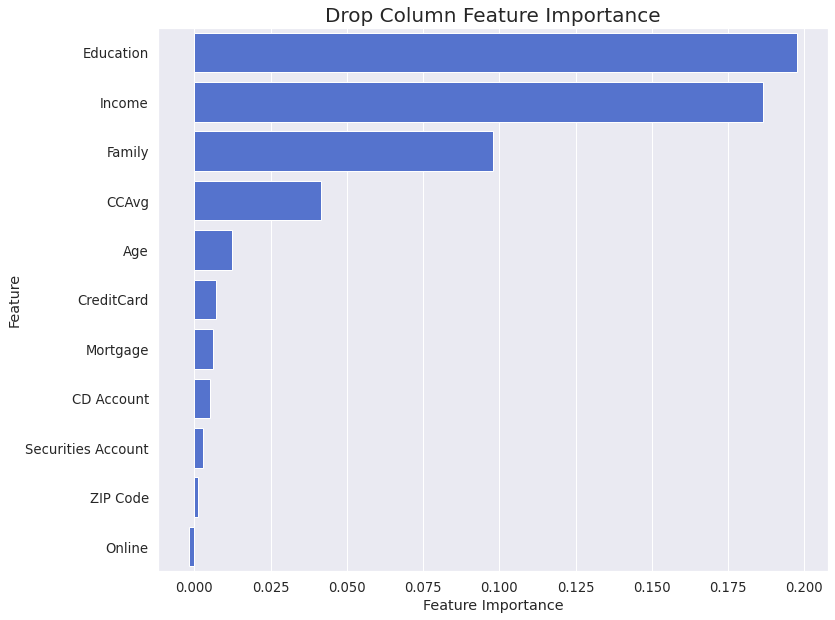

In [116]:
drop_column_importance_plot(xgb_opt, X_train, y_train)

The results of the feature importance analysis show that some of the features in the dataset contribute negatively towards making accurate predictions for the target variable. Therefore, we remove these features from our dataset:

In [117]:
# Find Important features
feature_importances = drop_column_importance(xgb_opt, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0.002]['feature'] # Threshold value of 0.002

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

Let's train our model again after removing the irrelevant features:

In [118]:
# Initialize the XGBoost Classifier
xgb = XGBClassifier(max_depth=5,
                    learning_rate=0.3,
                    n_estimators=200,
                    min_child_weight=1,
                    scale_pos_weight=1.5,
                    colsample_bytree=0.8,
                    gamma=0.1,
                    booster='gbtree',
                    objective='binary:logistic',
                    eval_metric='error', 
                    random_state=0)

# Train the XGBoost Classifier
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', gamma=0.1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 19.3: XGBoost Model Evaluation</p>

Let's evaluate our final XGBoost classifier performance using model_evaluation function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3915
   macro avg       1.00      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       892
           1       0.98      0.93      0.95        87

    accuracy                           0.99       979
   macro avg       0.98      0.96      0.97       979
weighted avg       0.99      0.99      0.99       979



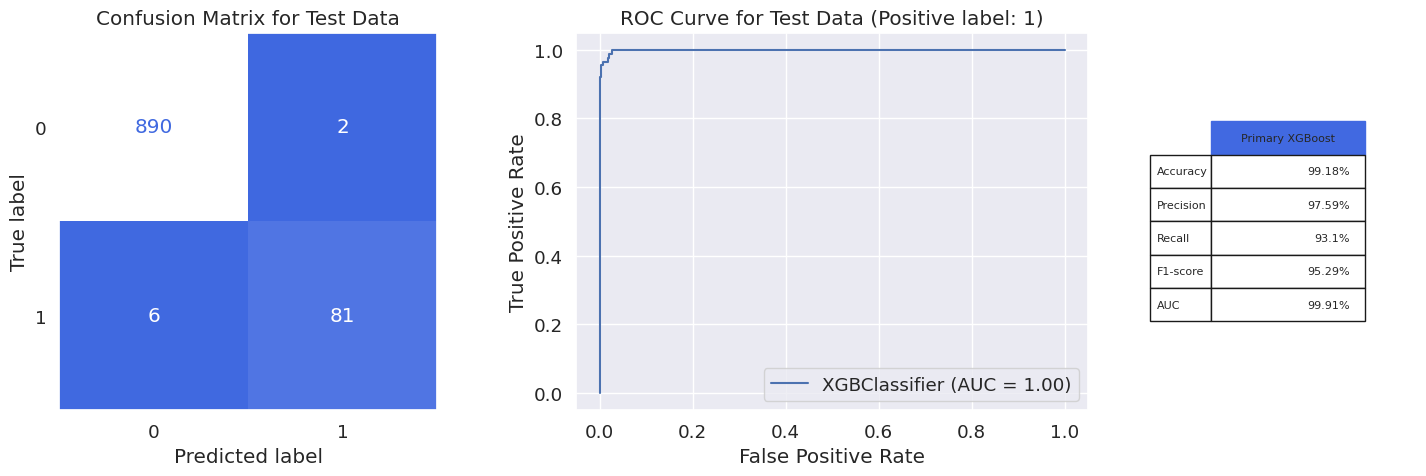

In [119]:
model_evaluation(xgb, X_train, X_test, y_train, y_test, 'Primary XGBoost')

The XGBoost classifier is fairly overfitting on the minority class and the hyperparameters need to be adjusted to reduce the variance and prevent overfitting.

<h4 align="left"><font color='royalblue'>How to reduce our XGBoost classifier variance?</font></h4>

> * __min_child_weight:__ We can increase the value of min_child_weight to control the complexity of the tree model and prevent overfitting.
>
> * __max_depth:__ We can decrease the max_depth to prevent the model from learning too much from the training data and reduce model variance.
>
> * __gamma:__ We can increase the value of gamma to control the minimum loss reduction required to make a split in order to reduce model variance.
>
> * __lambda:__ We can increase the value of lambda to add regularization and control overfitting.
>
> * __subsample:__ We can decrease the value of subsample to reduce the number of samples used to fit each tree and reduce model variance.
>
> * __colsample_bytree:__ We can decrease the value of colsample_bytree to reduce the number of features used in each tree and avoid overfitting.
>
> * __n_estimators:__ we can increase the number of trees to reduce the variance of the model.

Among the optimal values obtained for hyperparameters, we only decrease the value of max_depth from 5 to 4 in order to partially avoid overfitting:

In [120]:
# Initialize the XGBoost Classifier
xgb_final = XGBClassifier(max_depth=4,
                          learning_rate=0.3,
                          n_estimators=200,
                          min_child_weight=1,
                          scale_pos_weight=1.5,
                          colsample_bytree=0.8,
                          gamma=0.1,
                          booster='gbtree',
                          objective='binary:logistic',
                          eval_metric='error', 
                          random_state=0)

# Train the XGBoost Classifier
xgb_final.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', gamma=0.1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=4, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

Let's evaluate our final XGBoost classifier:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3915
   macro avg       1.00      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       892
           1       0.99      0.95      0.97        87

    accuracy                           0.99       979
   macro avg       0.99      0.98      0.98       979
weighted avg       0.99      0.99      0.99       979



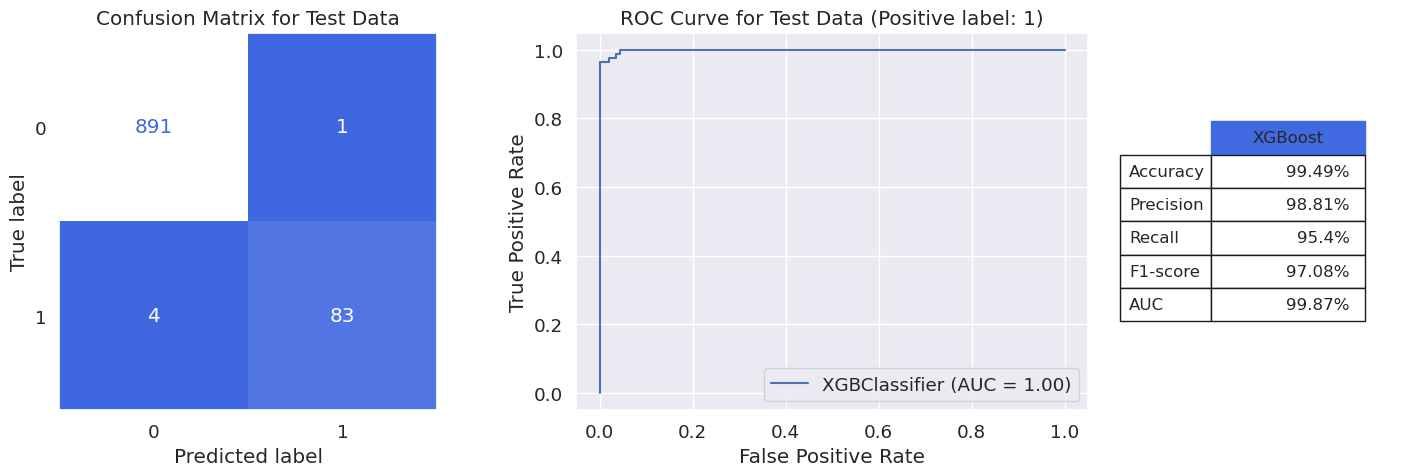

In [121]:
model_evaluation(xgb_final, X_train, X_test, y_train, y_test, 'XGBoost')

XGBoost classifier was our ultimate weapon to deal with our imbalanced dataset. As can be seen, we got the astonishing 97% f1-score with 99.87% AUC for our XGBoost classifier which is the best performance among all the classifiers reviewed. Out of 979 bank customers, the model made errors just in 5 cases to predict whether the customer accepts the loan or not.

In [122]:
# Save the final performance of XGBoost classifier
xgb_result = metrics_calculator(xgb_final, X_test, y_test, 'XGBoost')

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 20: Conclusion</p>

__As we explained earlier, the most important metric for this project is the f1-score for class '1'. A high f1-score indicates a balance between identifying as many potential loan customers as possible (high recall) and minimizing the number of false positives (high precision), which is crucial for the bank to increase the conversion rate of depositors to borrowers while reducing the cost of the marketing campaign.__

Next, we can check the performance of all previous classifiers based on metrics:

In [123]:
# Concatenate previous classifiers perfermance results into a single dataframe
results = pd.concat([cnb_result, bnb_result, logreg_result, knn_result, svm_result, dt_result,
           rf_result, et_result, ada_result, gbc_result, xgb_result], axis=1).T

# Sort the dataframe in descending order based on F1-score values
results.sort_values(by='F1-score', ascending=False, inplace=True)

# Color the F1-score column
results.style.applymap(lambda x: 'background-color: royalblue', subset='F1-score')

,Accuracy,Precision,Recall,F1-score,AUC
XGBoost,99.49%,98.81%,95.4%,97.08%,99.87%
Extra Trees,99.18%,98.77%,91.95%,95.24%,99.84%
Gradient Boosting,99.18%,98.77%,91.95%,95.24%,99.92%
AdaBoost,98.98%,96.39%,91.95%,94.12%,99.5%
Random Forest,98.98%,98.73%,89.66%,93.98%,99.81%
SVM,98.47%,93.9%,88.51%,91.12%,98.36%
K-Nearest Neighbors,98.47%,95.0%,87.36%,91.02%,97.0%
Decision Tree,98.47%,96.15%,86.21%,90.91%,97.48%
Logistic Regression,94.79%,72.5%,66.67%,69.46%,95.96%
Bernoulli Naive Bayes,93.87%,72.13%,50.57%,59.46%,94.51%


In the following, we can see the f1-score for class '1' of all previous classifiers in the form of a bar chart:

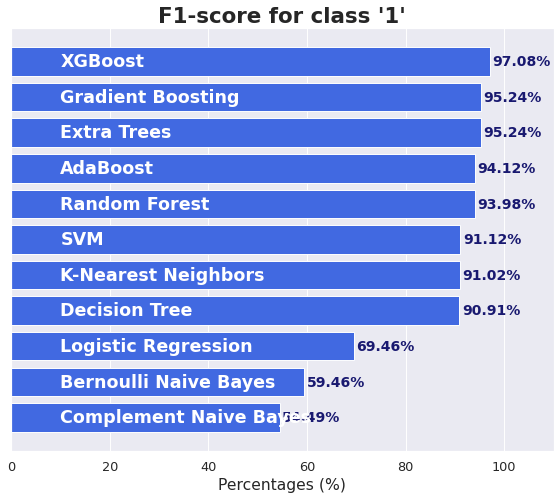

In [124]:
# Prepare values
results.sort_values(by='F1-score', ascending=True, inplace=True)
f1_scores = results['F1-score'].str.strip('%').astype(float)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(10, 8), dpi=70)
ax.barh(results.index, f1_scores, color='royalblue')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(f1_scores, results.index)):
    ax.text(value+0.5, i, f"{value}%", ha='left', va='center', fontweight='bold', color='midnightblue')
    ax.text(10, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=18)

# Remove yticks
ax.set_yticks([])

# Set x-axis limit
ax.set_xlim([0,110])

# Add title and xlabel
plt.title("F1-score for class '1'", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

🏆 __Among all the tested classifiers, 'XGBoost Classifier' had the best performance in identifying potential loan customers:__

* __Accuracy = 99.49%__
* __F1-score = 97.08%__
* __Precision = 98.81%__
* __Recall = 95.4%__
* __AUC = 99.87%__


🏆 __Based on previous feature importance graphs, among all features, Education, Income, Family, CCAvg and CD Account play the most important role in identifying potential loan customers.__

<h2 align="left"><font color='midnightblue'>Best Regards!</font></h2>